In [8]:
# default_exp fontlearner
%load_ext autoreload
%autoreload 2

# Font Learner

> Diffvg-based learner for font optimisation

## Imports

In [9]:
#export
from __future__ import annotations
from aifont.core import *
from collections import OrderedDict
from collections.abc import Iterable
from contextlib import contextmanager
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import ffmpeg
from nbdev.showdoc import *
from pandas import DataFrame
import PIL
from PIL.ImageOps import invert
import pydiffvg
from pydiffvg import Polygon, Rect, RenderFunction, save_svg, ShapeGroup
from pydiffvg import Path as VectorPath
from torch.distributions import Categorical
from torch.nn import Parameter
from typing import Callable, List, Protocol, Sequence, Tuple, Union

## Constants and Utilities

### General

In [10]:
#export

COLOR_BLACK     = tensor(0., 0., 0., 1.)
COLOR_WHITE     = tensor(1., 1., 1., 1.)
DEFAULT_SAMPLES = 6 # See notebook 5§9 for an analysis
EPS             = 1e-10 # Eps for, e.g. preventing div by 0
RGBA_TO_GS      = tensor(0.2989, 0.5870, 0.1140) # Crude NTSC weights for RGB channels

@contextmanager
def debug(obj, set_to=True, silent=False) -> None:
    """A context manager for enabling the `debug` parameter for any object
       that supports it. `no_debug` is a shorthand for `debug(False)`."""
    if not hasattr(obj, 'debug'):
        if not silent: warn(f"Object {obj} doesn't afford debug.")
        yield
    else:
        dbg = obj.debug
        obj.debug = set_to
        try: yield
        finally: obj.debug = dbg

no_debug = partial(debug, set_to=False)

@contextmanager
def eval_model(learner_or_model: Union[Learner, Module]) -> None:
    """A context manager for evaluating a `Learner` that restores the
       previous `training` state."""
    m = learner_or_model.model if isinstance(learner_or_model, Learner) else learner_or_model
    trn = m.training
    m.eval()
    try: yield
    finally:
        m.train(trn)

def get_argmin(df: DataFrame, argmin_col = "loss", return_col = "value") -> float:
    """Get the `return_col` value for the row with the lowest `argmin_col`.
       For use with `VectorLearner.calculate_losses`."""
    return df.iloc[df[argmin_col].argmin()][return_col]

def get_vocab(dls_or_learn: Union[DataLoaders, Learner]) -> List[str]:
    """Utility for getting the vocab from a Learner or DataLoaders."""
    if isinstance(dls_or_learn, Learner): dls_or_learn = dls_or_learn.dls
    vocab = dls_or_learn.vocab
    if type(vocab) == L and type(vocab[0]) == list: 
        if vocab[0] != vocab[1]: warn("The two vocabs in dls do not match! Using the first one.")
        vocab = vocab[0]
    return vocab

class DebugCB(Callback):
    """A `Callback` for debugging a `VectorRenderLayer`."""
    def __init__(self, vocal=False):
        super(DebugCB, self).__init__()
        self.vals = []
        self.grads = []
        store_attr()
    # def before_fit(self):
    #     self.model[0].params.retain_grad()
    def after_loss(self):
        if self.vocal: print(f"After loss: yb len = {len(self.yb)}")
    def before_backward(self):
        if self.vocal: print("Before backward")
    def before_step(self):
        m = self.model
        self.vals.append([ x.clone() for x in m.params])
        self.grads.append([x.grad.clone() if x.grad else tensor(0.) for x in m.params])
    def plot(self) -> None:
        # val = self.model[0].params[0].item()
        # grad_df.iloc[(grad_df.Vals - val).abs().argmin()]
        num = len(self.vals[0])
        def _items(tensor_list, idx): return [x.item() for x in tensor_list[idx]]
        plt.figure(figsize=(10,10))
        for i in range(num): plt.scatter(_items(self.vals, i), _items(self.grads, i), label=f"Param {i}")
        plt.legend()

### Letter Dimensions

In [11]:
#export

# Letter groups
# Crop the ends of strokes going beyond cap height or baseline
LETTERS_CROP_BOTH        = "AB DE FHI KLMN P R T VWXYZ"
LETTERS_CROP_TOP_ONLY    = "         J          U     "
# Pad vertex points by half stroke width
LETTERS_PAD_LEFT         = "ABCDEFGHIJKLMNOPQRS UVWXYZ"
LETTERS_PAD_RIGHT        = "ABCD  GHIJK MNOPQRS UVWXY "
LETTERS_PAD_TOP          = " BCDEFG       OPQRST     Z"
LETTERS_PAD_BOTTOM       = " BCDE G  J L  O Q S U    Z"
# The directions to apply overshoot to
LETTERS_OVERSHOOT_TOP    = "A C   G     MNO Q S       "
LETTERS_OVERSHOOT_BOTTOM = "  C   G  J   NO Q S UVW   "

class BoundingBox(GetAttr):
    """A simple object to hold the coordinates for the bounding box of 
       letter vertices."""
    def __init__(self, 
        left: Tensor, 
        top: Tensor, 
        right: Tensor, 
        bottom: Tensor):
        self.top_lft = self.top_left     = concat_tensors(left, top)
        self.top_rgt = self.top_right    = concat_tensors(right, top)
        self.btm_lft = self.bottom_left  = concat_tensors(left, bottom)
        self.btm_rgt = self.bottom_right = concat_tensors(right, bottom)
        self.width   = right - left
        self.height  = bottom - top
        store_attr()
    def __repr__(self):
        return "\n".join(["BoundingBox"] + [f"- {x}: {getattr(self, x).item()}" for x in "left,top,right,bottom".split(",")])
    @classmethod
    def from_points(cls,
        p1: Tensor,
        p2: Tensor,
        **kwargs
        ):
        """Create a `BoundingBox` from top-left and bottom-right corner points."""
        return cls(left = p1[0], top = p1[1], right = p2[0], bottom = p2[1], **kwargs)

def get_bounding_box(
    p_height: Tensor, 
    p_width: Tensor, 
    p_stroke_w: Tensor, 
    letter: str, 
    p_overshoot: Tensor = None,
    p_offset_x: Tensor = None,
    p_offset_y: Tensor = None
    ) -> BoundingBox:
    """Calculate the coordinates for the bounding box of vertices."""
    w = p_height * p_width if p_width is not None else p_stroke_w
    x1 = (1 - w) / 2
    x2 = x1 + w
    y1 = (1 - p_height) / 2
    y2 = y1 + p_height
    dw = p_stroke_w / 2
    if letter in LETTERS_PAD_LEFT:   x1 += dw
    if letter in LETTERS_PAD_RIGHT:  x2 -= dw
    if letter in LETTERS_PAD_TOP:    y1 += dw
    if letter in LETTERS_PAD_BOTTOM: y2 -= dw
    # Deal with situations where stroke_w > w
    for t in (x1, y1): t.clamp_(0., 0.5 - EPS)
    for t in (x2, y2): t.clamp_(0.5 - EPS, 1.)
    if p_overshoot:
        if letter in LETTERS_OVERSHOOT_TOP:    y1 -= p_overshoot
        if letter in LETTERS_OVERSHOOT_BOTTOM: y2 += p_overshoot
    if p_offset_x:
        x1 += p_offset_x
        x2 += p_offset_x
    if p_offset_y:
        y1 += p_offset_y
        y2 += p_offset_y
    bounds = [p_stroke_w, 1. - p_stroke_w]
    for t in (x1, y1, x2, y2): t.clamp_(*bounds)
    return BoundingBox(x1, y1, x2, y2)

### Vector Utilities

In [12]:
#export

# The bezier curvature value for a circle
CIRCLE_CURVATURE = 4 * (math.sqrt(2) - 1) / 3

class Bezier(TensorBase):
    """A simple wrapper for tensors describing quadratic beziers."""
    def __init__(self, coords: Union[Tensor, list[Tensor], list[float]]):
        assert type(coords) in (Tensor, list, tuple) and len(coords) == 8
        self.__new__(Bezier, coords)
    def at(self, t: Union[Tensor, float]) -> Tensor:
        """Evaluate the bézier at `t`."""
        assert t >= 0. and t <= 1.
        return cast((1 - t) ** 3 * self.p0 + \
                    3 * (1 - t) ** 2 * t * self.p1 + \
                    3 * (1 - t) * t ** 2 * self.p2 + \
                    t ** 3 * self.p3,
                    Tensor)
    def cut(self, t: Union[Tensor, float]) -> Tensor:
        """Cut the bézier at `t`."""
        def _mix(a, b): return (1 - t) * a + t * b
        pe = _mix(self.p0, self.p1)
        pf = _mix(self.p1, self.p2)
        pg = _mix(self.p2, self.p3)
        ph = _mix(pe, pf)
        pj = _mix(pf, pg)
        pk = _mix(ph, pj)
        # A,E,H,K and K,J,G,D
        return Bezier(concat_tensors(self.p0, pe, ph, pk, flatten=True))
    def plot(self, t: Union[Tensor, float] = None, x_lim = (0, 2), y_lim = (0, 2)) -> plt.Axes:
        """Plot the bézier with matplotlib."""
        Path = matplotlib.path.Path
        fig, ax = plt.subplots()
        pp1 = matplotlib.patches.PathPatch(
            Path(self.reshape(-1, 2), [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]),
            fc="none", transform=ax.transData
            )
        ax.add_patch(pp1)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        if t is not None:
            pt = self.at(t)
            ax.plot(pt[0], pt[1], "ro")
        plt.show()
        return ax
    @property
    def p0(self) -> Tensor: return cast(self[0:2], Tensor)
    @p0.setter
    def p0(self, val: Union[Tensor, float]) -> Tensor: self[0:2] = tensor(val)
    @property
    def p1(self) -> Tensor: return cast(self[2:4], Tensor)
    @p1.setter
    def p1(self, val: Union[Tensor, float]) -> Tensor: self[2:4] = tensor(val)
    @property
    def p2(self) -> Tensor: return cast(self[4:6], Tensor)
    @p2.setter
    def p2(self, val: Union[Tensor, float]) -> Tensor: self[4:6] = tensor(val)
    @property
    def p3(self) -> Tensor: return cast(self[6:8], Tensor)
    @p3.setter
    def p3(self, val: Union[Tensor, float]) -> Tensor: self[6:8] = tensor(val)

def pt(
    x: Union[Tensor, float],
    y: Union[Tensor, float]
    ) -> Tensor:
    """A shorthand to create a 2-element point tensor from two tensors or floats."""
    assert len(x) == len(y) == 1
    return concat_tensors(x, y, flatten=True)

def curve(
    rad_x: Union[Tensor, float],
    rad_y: Union[Tensor, float] = None,
    x: Union[Tensor, float] = 0.,
    y: Union[Tensor, float] = 0.,
    curvature: Union[Tensor, float] = CIRCLE_CURVATURE,
    ) -> Tuple[Tensor, List[int]]:
    """Create the necessary coordinate tensor and list of numbers of control 
       points to form a truncated curve Path that consists of the point of
       origin, one horisontal control point and the end point. For use with
       C, G and S. `x` and `y` define the top-left coordinates, `curvature` 
       controls handle extension as a fraction curve width. `rad_x` and 
       `rad_y` may be negative."""
    if rad_y is None: rad_y = rad_x
    pts = concat_tensors(x,                         y,
                         x + rad_x * curvature,     y,
                         x + rad_x,                 y + rad_y)
    cpts = [1]
    return pts, cpts

class BowlType(Enum):
    CIRCLE = auto()
    SEMICIRCLE_LEFT = auto()
    SEMICIRCLE_RIGHT = auto()
    SEMICIRCLE_TOP = auto()
    SEMICIRCLE_BOTTOM = auto()
    DEMICIRCLE_TOP_LEFT = auto()
    DEMICIRCLE_TOP_RIGHT = auto()
    DEMICIRCLE_BOTTOM_LEFT = auto()
    DEMICIRCLE_BOTTOM_RIGHT = auto()

DISTORT_KEY_STEMS = "top_rgt btm_rgt top_lft btm_lft".split(" ")
DISTORT_KEYS_X = [x + "_x" for x in DISTORT_KEY_STEMS]
DISTORT_KEYS_Y = [x + "_y" for x in DISTORT_KEY_STEMS]
DISTORT_KEYS = DISTORT_KEYS_X + DISTORT_KEYS_Y

def bowl(
    rad_x: Union[Tensor, float],
    rad_y: Union[Tensor, float] = None,
    x: Union[Tensor, float] = 0.,
    y: Union[Tensor, float] = 0.,
    curvature: Union[Tensor, float] = 4 * (math.sqrt(2) - 1) / 3,
    bowl_type: BowlType = BowlType.CIRCLE,
    distort: dict[str, Union[Tensor, float]] = {}
    ) -> Tuple[Tensor, List[int]]:
    """Create the necessary coordinate tensor and list of numbers of control 
       points to form a bowl Path. `x` and `y` define the top-left coordinates,
       `curvature` controls handle extension as a fraction of the relevant
       segment dimension, `dist_top_rgt_x` etc. are distortions as fractions of
       the relevant radius for each control point on either on the x or y axis
       and signed so that a negative distortion contracts the handle and a
       positive one extends it. `bowl_type` defines whether a full or 
       semicircle is drawn."""
    if rad_y is None: rad_y = rad_x
    cpt_x, cpt_y = rad_x * curvature, rad_y * curvature
    lft, rgt, top, btm, ctx, cty = x.clone(), x + 2 * rad_x, y.clone(), y + 2 * rad_y, x + rad_x, y + rad_y
    if bowl_type in (BowlType.SEMICIRCLE_RIGHT, BowlType.DEMICIRCLE_TOP_RIGHT, BowlType.DEMICIRCLE_BOTTOM_RIGHT): 
        lft -= rad_x
        ctx -= rad_x
        rgt -= rad_x
    if bowl_type in (BowlType.SEMICIRCLE_BOTTOM, BowlType.DEMICIRCLE_BOTTOM_LEFT, BowlType.DEMICIRCLE_BOTTOM_RIGHT): 
        top -= rad_y
        cty -= rad_y
        btm -= rad_y
    # Precalculate distortion and set missing to zero
    distort_calc = {}
    for k in DISTORT_KEYS:
        if k not in distort: distort_calc[k] = tensor(0.)
        else: distort_calc[k] = distort[k] * rad_x if k in DISTORT_KEYS_X else rad_y
    pts = []
    # Build the pts clockwise from the top
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_RIGHT, BowlType.DEMICIRCLE_TOP_RIGHT):
        # NB! If making changes here, also apply them to the last if segment
        pts += [# Top vertex
                ctx,                                        top,
                ctx + cpt_x + distort_calc["top_rgt_x"],    top,
                rgt,                                        cty - cpt_y - distort_calc["top_rgt_y"],
                # Right vertex
                rgt,                                        cty
                ]
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_RIGHT, BowlType.SEMICIRCLE_BOTTOM, BowlType.DEMICIRCLE_BOTTOM_RIGHT):
        if len(pts) == 0: pts = [rgt, cty]
        pts += [# Right vertex control points
                rgt,                                        cty + cpt_y + distort_calc["btm_rgt_y"],
                ctx + cpt_x + distort_calc["btm_rgt_x"],    btm,
                # Bottom vertex
                ctx,                                        btm
                ]
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_LEFT, BowlType.SEMICIRCLE_BOTTOM, BowlType.DEMICIRCLE_BOTTOM_LEFT):
        if len(pts) == 0: pts = [ctx, btm]
        pts += [# Bottom vertex control points
                ctx - cpt_x - distort_calc["btm_lft_x"],    btm,
                lft,                                        cty + cpt_y + distort_calc["btm_lft_y"],
                # Left vertex
                lft,                                        cty
                ]
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_LEFT, BowlType.SEMICIRCLE_TOP, BowlType.DEMICIRCLE_TOP_LEFT):
        if len(pts) == 0: pts = [lft, cty]
        pts += [# Left vertex control points
                lft,                                        cty - cpt_y - distort_calc["top_lft_y"],
                ctx - cpt_x - distort_calc["top_lft_x"],    top,
                # Top vertex
                ctx,                                        top
                ]
    if bowl_type == BowlType.SEMICIRCLE_TOP:
        # Finally add the top-right segment
        pts += [# Top vertex control points
                ctx + cpt_x + distort_calc["top_rgt_x"],    top,
                rgt,                                        cty - cpt_y - distort_calc["top_rgt_y"],
                # Right vertex
                rgt,                                        cty
                ]
    cpts = [2] * ((len(pts) - 1) // 6)
    return concat_tensors(*pts), cpts

class MaskDirection(Enum):
    DOWN = auto()
    UP = auto()

ANGLE_EPS = 1e-4

def terminal_mask(
    curve: Union[Tensor, Bezier],
    t: Union[Tensor, float] = None,
    area_p1 = tensor(0., 0.), 
    area_p2 = tensor(1., 1.),
    angle_deviation = tensor(0.),
    direction = MaskDirection.DOWN,
    fulcrum_pt = None
    ) -> Tensor:
    """Create a mask for cutting the Bézier `curve` at fraction `t`
       or at it's end point if None, at an angle defined matching a 
       line drawn from the fulcrum to the cut-off point rotated 
       towards vertical by `angle_deviation` radians. 
       The fulcrum defaults to bottom-left if `direction` is 
       down, top-right otherwise. The mask extends in `direction` to 
       cover the area defined by the corner point tensors `area_p1` 
       and `area_p2`."""
    if t is not None:
        if not isinstance(curve, Bezier): curve = Bezier(curve)
        term_pt = curve.at(t)
    else: term_pt = curve[-2:]
    area = BoundingBox.from_points(area_p1, area_p2)
    if fulcrum_pt is None: fulcrum_pt = area.btm_lft if direction == MaskDirection.DOWN else area.top_rgt
    term_dx = term_pt[0] - fulcrum_pt[0]
    term_dy = fulcrum_pt[1] - term_pt[1]
    angle = torch.atan(term_dy / term_dx) + angle_deviation
    angle.clamp_(ANGLE_EPS, math.pi/2 - ANGLE_EPS)
    # Extend the line to the edges of the area. The intersection may
    # fall on a vertical or a horisontal edge. Note that the direction
    # is clockwise, so with dir = DOWN pt 1 is on the left and with UP,
    # on the right.
    mask_dy_1 = torch.min(angle.tan() * term_dx, term_dy) if direction == MaskDirection.DOWN else \
                torch.max(angle.tan() * term_dx, term_dy)
    mask_dx_1 = mask_dy_1 / angle.tan() * -1
    mask_dy_2 = torch.min(angle.tan() * (area.right - term_pt[0]), term_pt[1] - area.top) * -1 \
                if direction == MaskDirection.DOWN else \
                torch.max(angle.tan() * (area.left  - term_pt[0]), term_pt[1] - area.bottom) * -1
    mask_dx_2 = mask_dy_2 * -1 / angle.tan()
    # Terminating line
    term_line = [term_pt[0] + mask_dx_1,   term_pt[1] + mask_dy_1,
                 term_pt[0] + mask_dx_2,   term_pt[1] + mask_dy_2]
    # Clockwise. NB. We make a zero-height spike in the btm-left/
    # top-right corner if the term line doesn't intersect with the
    # vertical edge, but this should have no effect.
    mask_pts = [area.btm_lft,
                *term_line,
                area.top_rgt,
                area.btm_rgt] if direction == MaskDirection.DOWN else \
               [area.top_rgt,
                *term_line,
                area.btm_lft,
                area.top_lft]
    return concat_tensors(*mask_pts, flatten=True)

def mirror(
    pts: Tensor,
    y: Union[Tensor, float]
    ) -> Tensor:
    """Mirrors `pts` vertically around a line going through `y`."""
    assert pts.ndim == 1
    res = pts.clone().reshape(-1, 2)
    res *= tensor([1., -1.])
    res[:, 1] = res[:, 1] + 2 * y
    return res.flatten()

def cut_semicircle(
    semicircle: Tensor,
    t: Union[Tensor, float]
    ) -> Tensor:
    """Cut a semicircle tensor at `t` while maintaining
        the number of points."""
    assert len(semicircle) == 14
    assert t >= 0. and t <= 1.
    # We split the semicircle into two demicircles and then cut accordingly
    cut = 2 * t
    cut_1 = torch.clamp(cut,     max=1.)
    cut_2 = torch.clamp(cut - 1, min=0.)
    dc_1 = Bezier(semicircle[:8]).cut(cut_1)
    dc_2 = Bezier(semicircle[6:]).cut(cut_2)
    # The second demicircle may be truncated at zero, which results in a point
    # artefact, so we have to move all points init to the end point of
    # the first demicircle. This is a GHASTLY hack...
    blend_f = torch.where(cut_2.bool(), 1., 0.)
    dc_2 = dc_2 * blend_f + (1 - blend_f) * dc_1[-2:].repeat(4)
    # Rebuild the semicircle, noting that the end point of dc_1 is shared
    return concat_tensors(dc_1, dc_2[2:], flatten=True)

## Rendering

### Scene

In [13]:
#export

Shape = Union[Rect, Polygon, VectorPath]

class Scene:
    """Just a utility to hold the different scene arguments together."""
    rf = RenderFunction
    def __init__(self, 
        shapes: list[any], 
        shape_groups: list[ShapeGroup], 
        canvas_width = 256, 
        canvas_height = 256, 
        samples = None
        ):
        assert shapes is not None and len(shapes) != 0
        assert shape_groups is not None and len(shape_groups) != 0
        if samples is None: samples = DEFAULT_SAMPLES
        self.last_seed: int = None
        store_attr()

    def get_scene_args(self) -> list:
        """Get the serialize scene for passing to `pydiffvg.RenderFunction`."""
        return self.rf.serialize_scene(self.canvas_width, self.canvas_height, self.shapes, self.shape_groups)

    def render(self, 
        seed: int = None, 
        do_render_grad = False
        ) -> Tensor:
        """Render the scene using pydffiv `RenderFunction` or its
           gradient if `do_render_grad`."""
        if seed is None: seed = random.randint(0, 1e6)
        self.last_seed = seed
        scene_args = self.get_scene_args()
        w,h = self.canvas_width,self.canvas_height
        s = self.samples
        args = [w, h, s, s, seed, None] + scene_args
        return self.rf.render_grad(torch.ones(w, h, 4, device=pydiffvg.get_device()), *args) \
               if do_render_grad else self.rf.apply(*args)

    def render_grad(self, 
        seed: int = None
        ) -> Tensor:
        """Render the gradient as raster."""
        return self.render(seed=self.last_seed, do_render_grad=True)

    def save_svg(self, 
        fn: Union[Path, str]
        ) -> None:
        """Save the scene as svg."""
        save_svg(ensure_path(Path(fn).with_suffix(".svg")), 
                 self.canvas_width, self.canvas_height, self.shapes, self.shape_groups)

add_docs(Scene)

### ImageSaver

In [14]:
#export
class ImageSaver:
    """Create a callback to pass to `VectorRenderLayer` as `rendered_callback`
       to save rendered images and optionally grads."""
    def __init__(self, 
        folder: str, 
        save_grad = False,
        save_svg  = False, 
        iter_name = "iter", 
        grad_name = "grad"
        ):
        assert folder is not None
        assert "_" not in iter_name and "_" not in grad_name
        if folder.endswith("/"): folder = folder[:-1]
        self.iter_files: List[str] = []
        self.grad_files: List[str] = []
        store_attr()

    def __call__(self, 
        raster: Tensor, 
        batch_i: int, 
        item_i: int, 
        scene: Scene = None,
        target = "",
        **kwargs
        ) -> None:
        assert not ((self.save_grad or self.save_svg) and scene is None)
        iter_sfx = f"_{batch_i}_{target}_{item_i}" # NB! This must match the template in render_grid
        img_fn  = f"{self.iter_name}{iter_sfx}"
        self.iter_files.append(self.save_image(raster, img_fn, **kwargs))
        if self.save_grad: self.grad_files.append(self.save_image(scene.render_grad(), f"{self.grad_name}{iter_sfx}", **kwargs))
        if self.save_svg: scene.save_svg(get_filepath(f"{img_fn}.svg"))

    def save_image(self, 
        raster: Tensor, 
        filename: str
        ) -> str:
        """Save the `raster` tensor as image file and return filename used."""
        r = raster.cpu()
        fn = get_filepath(f"{filename}.png")
        img = img_from_tensor(r)
        img.save(fn)
        return fn
    
    def render_result_video(self, 
        delete_imgs=False, 
        frame_rate=24, 
        grad=False
        ) -> None:
        """Render intermediate images as a video."""
        files = self.grad_files if grad else self.iter_files
        img = Image.open(files[0])
        canvas_height,canvas_width = img.height,img.width
        img.close()
        out = os.path.join(self.folder, "grads.mp4" if grad else "iters.mp4")
        frames = ffmpeg.input('pipe:', r=str(frame_rate))
        process = ffmpeg.input(f"color=c=white:s={canvas_width}x{canvas_height}", f="lavfi") \
                        .overlay(frames, eof_action="endall") \
                        .output(out) \
                        .overwrite_output() \
                        .run_async(pipe_stdin=True, quiet=True)
        for in_file in files:
            with open(in_file, 'rb') as f: process.stdin.write(f.read())
        # Close stdin pipe - FFmpeg fininsh encoding the output file.
        process.stdin.close()
        process.wait()
        if delete_imgs: 
            for f in files: os.remove(f)
        print("Rendering video done!")

    def render_grids(self,
        grid_name = "grid",
        grid_scale = 1.,
        vocal = True
        ) -> None:
        """Render grid versions of the individual rendered images."""
        def _render_grids(
            imgs = self.iter_files,
            name = self.iter_name
            ) -> None:
            batch_i = -1
            buffer = []
            for f in imgs:
                i = int(Path(f).stem.split("_")[1])
                if i != batch_i:
                    if len(buffer): image_grid(buffer, scale=grid_scale).convert('L').save(f"{self.folder}/{grid_name}_{name}_{batch_i}.png")
                    if vocal: print(f"Rendered batch {batch_i} of set {name}")
                    batch_i = i
                    buffer = []
                buffer.append(f)
        _render_grids()
        if self.save_grad: _render_grids(imgs=self.grad_files, name=self.grad_name)

    def get_filepath(self, fn) -> str:
        """Add folder to `fn` and ensure necessary dirs exist."""
        fn = Path(self.folder)/filename
        ensure_path(fn)
        return str(fn)

add_docs(ImageSaver)

## DataLoader

Simple `DataLoader` for getting letter classes.

In [15]:
#export
class LetterDL(DataLoader):
    """A dummy data loader for use with font vector optimisation.
       Pass the same `vocab` as in the OCR model. If `letters` is
       defined, items are restricted to those. Batch size defaults
       to the number of available items."""
    def __init__(self, 
        vocab: CategoryMap, 
        letters: Iterable[str] = None, 
        bs: int = None, 
        epoch_len = 10, 
        random = True,
        **kwargs
        ):
        assert vocab is not None
        if letters is None: letters = tuple(vocab)
        if bs is None: bs = len(letters)
        if not random and epoch_len * bs < len(letters): warn(f"Some of the letters will never be produced "
            "because random is False and epoch_len * bs is less than the number of letters.")
        super(LetterDL, self).__init__(bs=bs, n=epoch_len*bs, **kwargs)
        self.categorizer = Categorize(vocab=vocab)
        self.current_i: int
        self._letters: Iterable[str]
        store_attr("vocab,letters,epoch_len,random")
    @property
    def letters(self) -> Iterable[str]: return self._letters
    @letters.setter
    def letters(self, v: Iterable[str]):
        self._letters = v
        self.reset_i()
    def reset_i(self) -> None:
        """Call to reset `self.current_i` when `n` is reached. We randomise this if `self.n` isn't a
           multiple of the number of letters so that all letters are produced evenly."""
        residue = self.n % len(self.letters)
        self.current_i = 0 if residue == 0 else random.randint(0, residue)
    def create_item(self, s
        ) -> Tuple[TensorCategory, TensorCategory]:
        """Return the CategoryTensor for a random letter from `letters`."""
        if self.current_i == self.n: self.reset_i()
        r = self.categorizer.encodes(random.choice(self.letters) if self.random else \
            self.letters[self.current_i % len(self.letters)])
        self.current_i += 1
        return r, r.clone() # Y is a copy of x
    @classmethod
    def from_vocab(cls, 
        vocab: CategoryMap, 
        random = False, 
        **kwargs
        ):
        """Create a `LetterDL` using the whole `vocab`."""
        for x in ("letters", "bs"):
            if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")
            else: kwargs[x] = None
        return cls(vocab=vocab, random=random, **kwargs)
    
add_docs(LetterDL)

## Vector Model

The vector model consists of a `FontParamLayer`, which holds the parameters to optimise, and a subclass of `VectorRenderLayer`, which handles the creation of the letter vectors.

> Note that the utility of this bisection is tentative, and the params might as well be contained within the `VectorRenderLayer`.

### Font Parameters

Font parameters can be simple or specified to interpolate to certain ranges. 

The the order they are stored in the parameter layer. For each, a ParamRange tuple containing the min, max and optional mean values is passed, which are used to interpolate the value from the raw value, usually (–1, 1), passed by the parameter layer. Most values are treated as fractions, usually of cap height and, for Height, of canvas height. For standard ranges use the PRange enum.

In [16]:
#export

ParamDict = dict[str, Parameter]

PARAM_NAME_SEP = ", "

def compare_param_dicts(
    a: ParamDict, 
    b: ParamDict,
    vocal = False
) -> Union[None, Tuple[list[str], list[str]]]:
    """Compare `ParamDict`s and report discrepancies if `vocal`."""
    new     = [o for o in b.keys() if o not in a]
    missing = [o for o in a.keys() if o not in b]
    if len(new) or len(missing):
        if vocal: print(f"Params in b but not in a: {'; '.join(new)} • Params in a but not in b: {'; '.join(missing)}")
        return (new, missing)
    else: return None

def split_param(param_name: str) -> list[str, Union[str, None]]:
    """Split `param_name` into base name and affected letters"""
    parts = param_name.split(PARAM_NAME_SEP)
    assert len(parts) < 3
    return parts if len(parts) == 2 else parts + [None]

def join_param(base_name: str, letters: str = None) -> str:
    """Create a param name from `base_name` and affected `letters`."""
    return base_name if letters in (None, "") else \
           "".join((base_name, PARAM_NAME_SEP, *sorted(letters)))

def get_param_name(param_name: str) -> str:
    """Get the base name of `param_name`"""
    return split_param(param_name)[0]

def get_param_letters(param_name: str) -> Union[str, None]:
    """Get the letters `param_name` affects or `None` if not specified."""
    return split_param(param_name)[1]

def param_affects(param_name: str,
    letters: str,
    incl_general = True,
    strict = False,
    ) -> bool:
    """Check if `param_name` affects any of the `letters`. If `incl_general` 
       also returns `True` for general params. If `strict`, only return 
       parameters that affect no other `letters`."""
    assert not strict or not incl_general
    pl = get_param_letters(param_name)
    if pl is None: return incl_general
    for l in pl:
        if strict and l not in letters: return False
        if not strict and l in letters: return True
    return strict

def get_param_groups(param_names: list[str]
    ) -> OrderedDict:
    """Divide `param_names` into groups of parameters based on the letters they affect."""
    groups = {}
    for p in param_names:
        l = get_param_letters(p)
        l = '' if l is None else ''.join(sorted(l))
        if l in groups: groups[l].append(p)
        else:           groups[l] = [p]
    names = sorted(groups.keys(), key=lambda x: (x != '', -len(x), x))
    return OrderedDict({k: groups[k] for k in names})

def get_effective_params(param_names: list[str],
    letters: str,
    incl_general = False
    ) -> list[str]:
    """Get the parameters in `param_names` that affect `letters`."""
    return [o for o in param_names if param_affects(o, letters, incl_general=incl_general)]

class InitType(Enum):
    DEFAULT = auto()
    NEAR_ZERO = auto()
    ZERO = auto()

INIT_RANGE_DEFAULT = 2.
INIT_RANGE_NEAR_ZERO = .1

class ParamInterpolator(GetAttr):
    """Create an interpolator for sigmoid-activated param values passed
       by the `FontParamLayer`. Use `asymmetric` for values whose
       distribution is highest at `min` and tapers towards `max`."""
    def __init__(self, 
        min: float = None, 
        max: float = None, 
        asymmetric = False,
        init_type = InitType.DEFAULT
        ):
        if min is None: min = 0.
        if max is None: max = 1.
        if min == 0 and max == 0 and not asymmetric: self.noop = True
        min, max = tensor(min), tensor(max)
        self.v_range = max - min
        self.noop = False
        store_attr()
    def __call__(self, 
        x: Tensor
        ) -> Tensor:
        return self.interpolate(x)
    def interpolate(self, 
        x: Tensor
        ) -> Tensor:
        """Interpolate `x`."""
        if self.noop: return x
        if self.asymmetric:  x = x.pow(.333)
        return self.min + self.v_range * x
    def init_param(self, 
        x: Parameter,
        init_range = INIT_RANGE_DEFAULT) -> None:
        """Randomly initialise `x`."""
        if   self.init_type == InitType.ZERO:            x.data.zero_()
        elif self.init_type == InitType.NEAR_ZERO:       x.data.uniform_(-INIT_RANGE_NEAR_ZERO, INIT_RANGE_NEAR_ZERO)
        elif self.init_type in (InitType.DEFAULT, None): x.data.uniform_(-init_range, init_range)
        else: raise ValueError(f"Unknown init_type: {self.init_type}")

# Parameter ranges
NONZERO       = 0.05
XXSMALL       = 0.05
XSMALL        = 0.1
SMALL         = 0.25
NONFULL       = 0.9
LARGE         = 1.5
MAX_HEIGHT    = 0.8
DEFAULT_ANGLE = 45/180 * math.pi
ANGLE_90      = 90/180 * math.pi

PRANGE_DEFAULT   = ParamInterpolator( 0.0,     1.0)
PRANGE_DOUBLE    = ParamInterpolator( 0.0,     2.0)
PRANGE_LARGE     = ParamInterpolator( 0.0,     LARGE)
PRANGE_NONFULL   = ParamInterpolator( 0.0,     NONFULL)
PRANGE_HALF      = ParamInterpolator( 0.0,     0.5)
PRANGE_SMALL     = ParamInterpolator( 0.0,     SMALL)
PRANGE_XSMALL    = ParamInterpolator( 0.0,     XSMALL)
PRANGE_XXSMALL   = ParamInterpolator( 0.0,     XXSMALL)
PRANGE_BIDIR     = ParamInterpolator(-1.0,     1.0)
PRANGE_BIDIR_H   = ParamInterpolator(-0.5,     0.5)
PRANGE_BIDIR_S   = ParamInterpolator(-SMALL,   SMALL)
PRANGE_BIDIR_XS  = ParamInterpolator(-XSMALL,  XSMALL)
PRANGE_ZEROIN_XS = ParamInterpolator(-XSMALL,  XSMALL, init_type=InitType.NEAR_ZERO)
PRANGE_NONZERO   = ParamInterpolator( NONZERO, 1.0)
PRANGE_HEIGHT    = ParamInterpolator( NONZERO, MAX_HEIGHT)
PRANGE_NONZERO_H = ParamInterpolator( NONZERO, 0.5)
PRANGE_ASYM      = ParamInterpolator( 0.0,     1.0,    asymmetric=True)
PRANGE_ASYM_H    = ParamInterpolator( 0.0,     0.5,    asymmetric=True)
PRANGE_ASYM_S    = ParamInterpolator( 0.0,     SMALL,  asymmetric=True)
PRANGE_ASYM_XS   = ParamInterpolator( 0.0,     XSMALL, asymmetric=True)
PRANGE_ANGLE     = ParamInterpolator( -DEFAULT_ANGLE, DEFAULT_ANGLE)
PRANGE_ANGLE_90  = ParamInterpolator( 0.0,     ANGLE_90)
PRANGE_STROKE    = ParamInterpolator( 0.01,    0.25)
PRANGE_WIDTH     = ParamInterpolator( SMALL,   LARGE) # Force a min width to prevent unrecoverable collapse

DEFAULT_FONT_PARAM_SPECS = OrderedDict({
    "Height": PRANGE_HEIGHT,
    # "Slant": PRANGE_BIDIR,
    "Midline": PRANGE_DEFAULT,
    "Stroke width": PRANGE_STROKE,
    "Bowl curvature": PRANGE_DEFAULT, # Superness: 0: cross, 1: lozenge, 2: circle: Inf: square
    "Width, AV": PRANGE_WIDTH,
    "Width, BPR": PRANGE_WIDTH,
    "Width, D": PRANGE_WIDTH,
    "Width, EF": PRANGE_WIDTH,
    "Width, CGOQ": PRANGE_WIDTH, # NB. This is the final width for only O
    "Width, HNU": PRANGE_WIDTH,
    "Width, J": PRANGE_WIDTH,
    "Width, K": PRANGE_WIDTH,
    "Width, L": PRANGE_WIDTH,
    "Width, M": PRANGE_WIDTH,
    "Width, S": PRANGE_WIDTH,
    "Width, TZ": PRANGE_WIDTH,
    "Width, W": PRANGE_WIDTH,
    "Width, XY": PRANGE_WIDTH,
    "Width n difference from O, C": PRANGE_ASYM_S,
    "Width n difference from E, F": PRANGE_ASYM_S,
    "Width n difference from O, G": PRANGE_ASYM_S,
    "Offset x from symmetry, AXZ": PRANGE_BIDIR_S,
    "Overshoot, AMNVW":  PRANGE_XSMALL,  # An option is to allow negative values for this
    "Overshoot, CGJOSQ": PRANGE_XXSMALL, # See: https://en.wikipedia.org/wiki/Overshoot_(typography)
    "Crossbar y offset, A": PRANGE_BIDIR_H,
    "Crossbar y offset, B": PRANGE_BIDIR_H,
    "Crossbar y offset, G": PRANGE_BIDIR_H,
    "Crossbar y offset, P": PRANGE_BIDIR_H,
    "Crossbar y offset, R": PRANGE_BIDIR_H,
    "Crotch y offset, Y": PRANGE_BIDIR_H,
    "Crossbar length, G": PRANGE_NONFULL,
    "Bar stem height, G": PRANGE_DEFAULT,
    "Bowl aspect ratio, BPR": PRANGE_DOUBLE,
    "Bowl aspect ratio, D": PRANGE_DOUBLE,
    "Bowl aspect ratio, J": PRANGE_DOUBLE,
    "Bowl aspect ratio, U": PRANGE_DOUBLE,
    "Bowl distortion, BPR": PRANGE_ASYM_S,
    # "Bowl distortion, G": PRANGE_ASYM_S,
    "Bowl distortion, J": PRANGE_ASYM_S,
    "Upper bowl xn offset, B": PRANGE_ASYM_S,
    "Upper width n difference, E": PRANGE_ASYM_S,
    "Upper bowl ratio to lower, S": PRANGE_NONZERO,
    "Upper bowl xp offset, S": PRANGE_ASYM_S,
    "Upper width n difference, X": PRANGE_ASYM_S,
    "Upper width n difference, Z": PRANGE_ASYM_S,
    "Middle width n difference, E": PRANGE_ASYM_S,
    "Middle width n difference, F": PRANGE_ASYM_S,
    "Aperture, CGS": PRANGE_NONZERO,
    "Aperture, J": PRANGE_NONZERO,
    "Arm xn offset, K": PRANGE_ASYM_S,
    "Stem-arm connection height, K": PRANGE_DEFAULT,
    "Arm-leg connection location, K": PRANGE_DEFAULT,
    "Stem xp offset from vertical, M": PRANGE_ASYM_S,
    "Tail angle, Q": PRANGE_ANGLE_90,
    "Tail length, Q": PRANGE_NONZERO_H,
    "Tail-bowl connection location, Q": PRANGE_DEFAULT,
    "Tail inside fraction, Q": PRANGE_DEFAULT,
    "Leg xp offset, R": PRANGE_ASYM_S,
    "Leg-bowl connection location, R": PRANGE_DEFAULT,
    "Leg distortion, R": PRANGE_ASYM_H,
    # Not implemented bc it would too much work to sharpen all corners to match the behaviour
    # "Termination angle deviation, CGJS": PRANGE_ANGLE
    })
# These additional parameters are needed for font matching
OFFSET_PARAM_SPECS = OrderedDict({
    "Offset y": PRANGE_ZEROIN_XS
    })
for l in VOCAB_UC: OFFSET_PARAM_SPECS[f"Offset x, {l}"] = PRANGE_ZEROIN_XS
FONT_MATCHING_PARAM_SPECS = OrderedDict(
    **DEFAULT_FONT_PARAM_SPECS,
    **OFFSET_PARAM_SPECS
    )

### Vector Rendering Layer Base

> The base for font models.

In [17]:
#export

class Normaliser(Protocol):
    """For normalising rasters for the OCR."""
    mean: float
    std: float

class VectorRenderLayerBase(Module):
    """Base for vector render layers. Get's input from a FontParamLayer
       and returns the diffvg rendering. Override `create_scenes` in
       subclasses and save the results in `self.scenes` of which there
       should be `bs`. `forward` calls `render` which renders the
       scenes and permutes to match the OCR model. Note that the workflow
       is based on greyscale images and we're only using the alpha value
       of the diffvg render output.

       Params can be defined simply with `n_params` or an `OrderedDict` 
       `param_specs` that contains each parameter's name and a 
       `ParamInterpolator` to which the activated param values is passed.
       All params have sigmoid activation and, thus, have an output range
       of [0, 1] before possible interpolation.
       
       Init parameters:
       `canvas_width`, `canvas_height`: rastered canvas dims
       `raster_norm`: use the normaliser from the OCR `dls`
       `clip_raster`: whether to clip color values to [0., 1.] as is done when
            saving image (note that the values produced by the render
            function value wildly up to more than 10. so setting this to
            False is advised against)
       `apply_gamma`: whether to apply `gamma` to the color values similarly
            to clipping above
       `n_params`: number of params (with sigmoid activation). Either this or
            `param_specs` must be passed.
       `param_specs`: `OrderedDict` that contains each parameter's name and a 
            `ParamInterpolator` to which the activated param values is passed
            or a list of these if names are not used.
       `vocab`: list of letter strings to which the inputs are matched
       `init_range`: defines the range of the   pre-activation parameter 
            value space when initialised at random by `reset_parameters` 
            centered around the middle.
       `eps`: amount of random jitter added to params, use with care!
       `n_colors_out`: color channels out
       `max_distance`: the maximum fraction [0., 1.] of canvas dims 
            `distance_params` can span
       `fixed_seed`: fixed seed value to pass to `pydiffvg.RenderFunction`
       `gamma`: set to override default gamma of 2.2 for colour images and 1.
            for grayscale ones
       `stroke_width`: stroke width for shape generator helpers
            (note that this is defined as a fraction of `canvas_size`);
            either a float or a tuple of min and max width and used by
            `expand_stroke_width`
       `stroke_color`: default stroke color for shape generator helpers
       `samples`: passed to `diffvg.RenderFunction` when rendering scenes
       `rendered_callback`: set to an ImageSaver to save interim renders"""
    def __init__(self, canvas_width: int, canvas_height: int, vocab: CategoryMap, 
                 param_specs: Union[OrderedDict, List[ParamInterpolator]] = None, 
                 n_params: int = None, seed: int = None, 
                 init_range = 2., eps: float = None, raster_norm: Normaliser = None, clip_raster = True, 
                 apply_gamma = True, n_colors_out = 1, max_distance = 1., fixed_seed: int = None, 
                 gamma: float = None, stroke_width: Union[float, Tuple[float, float]] = 1./28, 
                 stroke_color = COLOR_BLACK,  samples: int = None,
                 rendered_callback: ImageSaver = None):
        if max_distance is None: max_distance = 1.
        assert max_distance <= 1.
        if param_specs is not None: n_params = len(param_specs)
        assert n_params is not None and vocab is not None
        if seed is not None: torch.random.manual_seed(seed)
        super(VectorRenderLayerBase, self).__init__()
        self.batch_i = -1
        self.bs: int
        self.debug = False
        self.i: int # Current item index
        self.eps_tensor: Tensor
        self.param_interpolators: List[ParamInterpolator]
        self.param_names: List[str]
        self.scenes: List[Scene] = []
        self.sigmoid = torch.nn.Sigmoid()
        self.stored = []
        self.weight: List[Parameter] = []
        self.x: Tensor
        if param_specs:
            if isinstance(param_specs, OrderedDict):
                self.param_names = list(param_specs.keys())
                self.param_interpolators = list(param_specs.values())
            elif isinstance(param_specs, list):
                self.param_interpolators = param_specs
            else: raise ValueError("param_specs must of the type Union[OrderedDict, List[ParamInterpolator]]")
        self.weight = []
        for i in range(n_params):
            p = Parameter(torch.rand([])) # Can't use zeros or empty as they do not create a new Parameter instance!
            n = self.param_names[i] if self.param_names else str(i)
            self.register_parameter(n, p) # We need to do this manually as we are not saving the params as attributes
            self.weight.append(p)
        stroke_width = tensor(stroke_width)
        if canvas_width != canvas_height: 
            warn(f"When canvas is not square ({canvas_width}x{canvas_height}), "
                  "some dimensions may be expanded outside it.")
        if gamma is None: gamma = 1. if n_colors_out == 1 else 2.2
        store_attr()
        self.reset_parameters()

    def __repr__(self):
        p_strings = []
        i_pad = math.ceil(math.log(len(self.params), 10))
        name_pad = max([len(x) for x in self.param_names])
        for i, p in enumerate(self.params):
            s = f"  {i:{i_pad}}"
            if self.param_names: s += f" {self.param_names[i]:{name_pad}} "
            s += f"{p.item(): .2f} ({self.get_param_value(i, no_eps=True).item(): .2f})"
            if not p.requires_grad: s += " <FROZEN>"
            p_strings.append(s)
        return "\n".join([f"{self.__class__.__name__} with params:"] + p_strings)

    def show_params(self, letters: str = None, filter: str = None) -> None:
        """Show the model's parameters and their values, possibly limited to those
           specifically affecting `letters` and matching regex `filter`."""
        out = self.__repr__()
        if letters or filter:
            out = "\n".join([x for x in out.split("\n") if 
                            (not letters or re.search(f", {letters}", x)) and
                            (not filter  or re.search(filter, x))])
        print(out)

    @property
    def canvas_size(self) -> int:
        """The bigger of the canvas dimensions."""
        return max(self.canvas_width, self.canvas_height)

    @property
    def params(self) -> List[Tensor]:
        """A synomym for `weight`. Note that the result is list of parameter tensors."""
        return self.weight

    def reset_parameters(self, init_range=None):
        """Randomly init the parameters around the middle of possible values."""
        for p in self.params: self.reset_param(p, init_range=init_range)

    def reset_param(self, param: Union[str, int, Parameter], init_range=None) -> None:
        """Randomly init the parameter."""
        if init_range is None: init_range = self.init_range
        p = self.get_param(param)
        if pi := self.get_param_interpolator(p): pi.init_param(p, init_range)
        else: p.data.uniform_(-init_range, init_range)

    def get_param_value(self, param: Union[str, int, Parameter], no_eps = False) -> Tensor:
        """Get interpolated param value by `param`."""
        idx = self.get_param_index(param)
        p = self.get_param(idx)
        v = self.sigmoid(p if no_eps or not self.eps else p + self.eps_tensor[idx])
        pi = self.get_param_interpolator(idx)
        return pi(v) if pi else v

    def get_param_value_for_letter(self, param_name: str, letter: str = None, default_val: Union[Tensor, float] = None, **kwargs) -> Union[Tensor, None]:
        """A utility method that uses either the `letter` argument of `self.i`
           to construct the param name."""
        assert self.param_names
        assert "," not in param_name
        if letter is None: letter = self.get_letter()
        for k in self.param_names:
            if get_param_name(k) == param_name and param_affects(k, letter): return self.get_param_value(k, **kwargs)
        # raise ValueError(f"No matching parameter for {param_name} and {letter}.")
        return None if default_val is None else tensor(default_val)

    def get_param(self, param: Union[str, int, Parameter]) -> Parameter:
        """Get the param object by `param`."""
        return param if isinstance(param, Parameter) else self.params[self.get_param_index(param)]

    def get_param_dict(self) -> ParamDict:
        """Get a `dict` containing all parameters and their values."""
        return {n: self.get_param(n).item() for n in self.param_names}

    def get_param_index(self, param: Union[str, int, Parameter]) -> int:
        """Get the index of the param."""
        if type(param) is int: return param
        return self.params.index(param) if isinstance(param, Parameter) else self.param_names.index(param)

    def get_param_name(self, param: Union[str, int, Parameter]) -> int:
        """Get the name of the param."""
        assert self.param_names
        return param if type(param) is str else self.param_names[self.get_param_index(param)]

    def get_param_interpolator(self, param: Union[str, int, Parameter]) -> Union[ParamInterpolator, None]:
        """Get the param interpolator for `param`."""
        if not self.param_interpolators: return None
        return self.param_interpolators[self.get_param_index(param)]

    def load_param_dict(self, param_dict: ParamDict, vocal = True, clip:float = None) -> None:
        """Set param values based on `param_dict` optionally clipping abs values at `clip`."""
        comp = compare_param_dicts(self.get_param_dict(), param_dict, vocal=vocal)
        new  = comp[0] if comp is not None else []
        for p,v in param_dict.items():
            if p not in new:
                if clip is not None: v = max(min(v, clip), -clip)
                self.set_param(p, v)

    def set_param(self, param: Union[str, int, Parameter], value: Union[float, Tensor]) -> None:
        """Set the value for the param by `param`. Mostly for debugging."""
        self.get_param(param).data = tensor(value)

    def get_param_groups(self) -> OrderedDict:
        """Get param names grouped by the letters they affect."""
        return get_param_groups(self.param_names)

    def get_effective_params(self, letters: str, **kwargs) -> list[str]:
        """Get param names that affect `letters`."""
        return get_effective_params(self.param_names, letters, **kwargs)

    def freeze_params(self, params: list[Union[str, int, Parameter]], set_to = False) -> None:
        """Freeze the one or more params by `params` or all of them if no `params` are given."""
        pp = self.params if len(params) == 0 else [self.get_param(n) for n in params]
        for p in pp: p.requires_grad = set_to

    def unfreeze_params(self, params: list[Union[str, int, Parameter]]) -> None:
        """Unfreeze the one or more params by `params`."""
        self.freeze_params(params, set_to=True)

    def get_letter(self, i: int = None) -> string:
        """Get letter as string for item `i`."""
        if i is None: i = self.i
        return self.vocab[self.get_input(i).int().item()]

    def get_input(self, i: int) -> Tensor:
        """Get the letter category for item `i` in `x`"""
        return self.x[i]

    def add_eps(self) -> None:
        """Apply random eps to params. 
           Cf. diffvg/apps/generative modeling/rendering.render_lines"""
        if not self.eps: return
        self.eps_tensor = self.eps * torch.randn(self.n_params)

    def expand_distance(self, vals: Tensor) -> Tensor:
        """Expand values to a central `self.max_distance` fraction of the canvas.
           Coordinates originate from NW."""
        return self.canvas_size * vals if self.max_distance == 1. else \
               self.canvas_size * ((1 - self.max_distance) / 2 + vals * self.max_distance)

    def expand_stroke_width(self, vals: Tensor = None) -> Tensor:
        """Expand `vals`,  based on `[min_stroke_width, max_stroke_width] * canvas_height`.
           Note that we divide by two so that result is in line with traditional usage in
           vector software."""
        if vals is None: 
            warn("Using default stroke width in rendering.")
            vals = tensor(1.)
        w = vals * self.stroke_width if self.stroke_width.ndim == 0 \
            else self.stroke_width[0] + vals * (self.stroke_width[1] - self.stroke_width[0])
        return w * self.canvas_size / 2

    def normalise_raster(self, raster: Tensor) -> Tensor:
        """Apply normalisation to `raster`. Not useful for grayscale letters."""
        if not self.raster_norm: return raster
        return (raster - self.raster_norm.mean) / self.raster_norm.std 

    def forward(self, x) -> Tensor:
        """Render letters defined in `x`."""
        self._forward(x)
        return self.render()

    def _forward(self, x) -> None:
        """Prepare for rendering"""
        if x.ndim == 1: x = x.unsqueeze(1)
        elif x.ndim != 2: raise ValueError("Input can only be 1- or 2-dimensional.")
        self.batch_i += 1
        self.x = x
        self.bs = x.size(0)
        self.add_eps()
        self.scenes = [None] * self.bs
        self.create_scenes()

    def save_svg(self,
        fn_stem: Union[Path, str],
        letter: str = "A", 
        ) -> None:
        """Save one or more letters as svg."""
        x = tensor([self.vocab.index(o) for o in letter])
        with eval_model(self):
            with torch.no_grad(): self._forward(x) # Create Scenes
        for l,s in zip(letter, self.scenes): s.save_svg(f"{fn_stem}_{l}")

    def create_scenes(self) -> None:
        """Override this in subclasses to create the vector scenes for the letters."""
        raise NotImplementedError()

    def create_line_scene(self, shapes: list[Shape]) -> Scene:
        """Create a simple line-drawing Scene with shapes."""
        shape_groups = [self.create_line_group(shapes)]
        return self.create_scene_from_groups(shapes, shape_groups)

    def create_line_group(self, shapes: list[Shape], stroke_color=None, id_offset=0) -> ShapeGroup:
        """Create a ShapeGroup from shapes for line drawing."""
        if stroke_color is None: stroke_color = self.stroke_color
        return ShapeGroup(shape_ids=tensor([x + id_offset for x in range(len(shapes))]),
                          fill_color=None,
                          stroke_color=stroke_color,
                          use_even_odd_rule=False)

    def create_fill_group(self, shapes: list[Shape], fill_color=None, id_offset=0) -> ShapeGroup:
        """Create a ShapeGroup from shapes for filling."""
        if fill_color is None: fill_color = self.stroke_color
        return ShapeGroup(shape_ids=tensor([x + id_offset for x in range(len(shapes))]),
                          fill_color=fill_color,
                          stroke_color=None,
                          use_even_odd_rule=True)

    def create_scene_from_groups(self, shapes: list[Shape], shape_groups: list[ShapeGroup]) -> list:
        """Create a scene from `shapes` and `shape_groups`."""
        # Check that there are no duplicate ids
        all_ids = torch.concat([x.shape_ids for x in shape_groups])
        assert all_ids.numel() == all_ids.unique().numel()
        return Scene(shapes=shapes, shape_groups=shape_groups, 
                     canvas_width=self.canvas_width, canvas_height=self.canvas_height,
                     samples=self.samples)
    
    def create_scene_from_shapes(self, shapes_and_types: list[Tuple[Shape, bool]], stroke_color=None, 
                                 fill_color=None, bg_color=None) -> list:
        """Create a scene from `shapes_and_types`, which are tuples of a `Shape` and a boolean 
           indicating whether the shape is a filled one (`True`) or a line shape. The scene can 
           optionally have a background."""
        shapes = []
        shape_groups = []
        id_offset = 0
        if bg_color is not None:
            bg = Rect(tensor(0., 0.), tensor(self.canvas_width, self.canvas_height), stroke_width=tensor(0.))
            g = self.create_fill_group([bg], fill_color=bg_color, id_offset=id_offset)
            shapes.append(bg)
            shape_groups.append(g)
            id_offset += 1
        for s, f in shapes_and_types:
            g = self.create_fill_group([s], fill_color=fill_color, id_offset=id_offset) if f else \
                self.create_line_group([s], stroke_color=stroke_color, id_offset=id_offset)
            shapes.append(s)
            shape_groups.append(g)
            id_offset += 1
        return self.create_scene_from_groups(shapes, shape_groups) 
    
    def create_mixed_scene(self, line_shapes: list[Shape] = [], fill_shapes: list[Shape] = [], **kwargs) -> list:
        """Create a scene that has both `line_shapes` and `fill_shapes` and optionally a background.
           A shortcut for `create_scene_from_shapes`."""
        shapes_and_types = [(s, False) for s in line_shapes] + [(s, True) for s in fill_shapes]
        return self.create_scene_from_shapes(shapes_and_types, **kwargs)

    def create_line_scene_from_points(self, point_tensors: list[Tensor], **kwargs) -> Scene:
        """Shorthand for `create_line_scene` by passing `point_tensors` that
           are converted to polygons."""
        return self.create_line_scene(*self.points_to_polygons(point_tensors, **kwargs))

    def points_to_beziers(self, point_tensors: list[Tensor], n_control_pts: Union[None, list] = None, 
                          force = False, **kwargs) -> list[Polygon]:
        """Convert `point_tensors` to a List of pydiffvg Paths. `n_control_pts` 
           sets the number of control points. It should be a list 
           If it's None, control points are set to zero, i.e., the path is
           rendered as a polyline."""
        assert type(point_tensors) is list
        if n_control_pts is None: n_control_pts = [None] * len(point_tensors)
        assert type(n_control_pts) is list and len(point_tensors) == len(n_control_pts)
        bezier_control_pts = []
        for pt, cpt in zip(point_tensors, n_control_pts):
            assert len(pt) >= 4, "The Bézier must have at least two points"
            if cpt is None: bezier_control_pts.append(tensor([0] * (len(pt) // 2 - 1)))
            elif type(cpt) is list: 
                if not force and pt.numel() / 2 != sum(cpt) + len(cpt) + 1:
                    raise ValueError(f"Number of control points {sum(cpt) + len(cpt) + 1} does not fit path with {pt.numel() / 2} points. "
                          "Use force=True to override.", pt, cpt)
                bezier_control_pts.append(tensor(cpt))
            else: raise ValueError("n_control_pts must be of type Union[None, list]")
        return self.points_to_shapes(VectorPath, point_tensors, bezier_control_pts=bezier_control_pts, **kwargs)

    def points_to_polygons(self, point_tensors: list[Tensor], **kwargs) -> list[Polygon]:
        """Convert `point_tensors` to a List of pydiffvg Polygons."""
        return self.points_to_shapes(Polygon, point_tensors, **kwargs)

    def points_to_shapes(self, shape_cls, point_tensors: list[Tensor], stroke_width: Tensor = None, 
                         is_closed = False, expand_distance = False,
                         bezier_control_pts: list[Tensor] = None) -> list:
        """Convert `point_tensors` to a List of pydiffvg shapes of `shape_cls`."""
        assert type(point_tensors) is list
        args = dict(stroke_width=self.expand_stroke_width() if stroke_width is None else stroke_width,
                    is_closed=is_closed)
        shapes = []
        for i, pt in enumerate(self.reshape_points(point_tensors)):
            if expand_distance: pt = self.expand_distance(pt)
            if shape_cls is VectorPath: args["num_control_points"] = bezier_control_pts[i]
            shapes.append(shape_cls(points=pt, **args))
        return shapes

    def reshape_points(self, point_tensors: list[Tensor]) -> list[Tensor]:
        """Ensure that `point_tensor` has a shape of `(N, 2)`."""
        assert type(point_tensors) is list
        return [t if t.ndim == 2 else t.reshape(-1, 2) for t in point_tensors]

    def render(self) -> Tensor:
        """Render `self.scenes` as a raster tensor using pydiffvg."""
        assert self.scenes is not None and len(self.scenes) == self.bs
        cols = self.n_colors_out
        output = torch.zeros(self.bs, cols, self.canvas_width, self.canvas_height) # .requires_grad_()
        for i, s in enumerate(self.scenes):
            raster = s.render(seed=self.fixed_seed)
            if self.rendered_callback: 
                self.rendered_callback(raster=raster, batch_i=self.batch_i, item_i=i, scene=s, target=self.get_letter(i))
            if cols in (1, 3):
                # Output is w,h,rgba, where with values in 0.-1. (and black thus 0., 0., 0., 1.)
                # First, we apply alpha by mixing output with white in that proportion
                if self.debug: self.stored.append(raster.clone())
                alpha = raster[:, :, 3].unsqueeze(2).expand(-1, -1, 4)
                white = torch.full_like(raster, 1.) * (1. - alpha)
                raster = (white + raster * alpha)[:, :, :3] # Now raster is w,h,rgb
                if cols == 1: # Convert to grayscale if needed
                    raster *= RGBA_TO_GS # This is a crude NTSC sampling to grayscale
                    raster = raster.sum(-1, keepdims=True)
                raster = raster.permute(2, 0, 1) # Order channel-first
            elif cols != 4: raise NotImplementedError(f"n_colors_out '{cols}' can only be 1, 3 or 4.")
            raster = self.normalise_raster(raster)
            if self.clip_raster: raster = raster.clip(0., 1.)
            if self.apply_gamma: 
                if cols == 1: raster = raster.pow(1.0/self.gamma)
                else: raster[:,:,:3] = raster[:,:,:3].pow(1.0/self.gamma)
            # assert raster.requires_grad
            output[i] = raster
        return output

add_docs(VectorRenderLayerBase)

### Sans Serif Font Model

> The first sans-serif font rendering layer model with all 26 uppercase alphabets. Note that this model relies heavily the constant `DEFAULT_FONT_PARAM_SPECS`, above, although that can be overriden upon initialisation.

In [18]:
#export

class SansSerifFontRL(VectorRenderLayerBase):
    """A model for rendering a whole sans serif font. Init takes `vocab`
       to define which letters are allowed. `param_specs` defines the 
       value ranges for the parameters (see source)."""
    
    def __init__(self, param_specs: OrderedDict = DEFAULT_FONT_PARAM_SPECS, max_distance=1.0, **kwargs):
        assert param_specs is not None
        assert max_distance == 1.0, "Do not use max_distance with SansSerifFontRL"
        # Note that we allow the full range for stroke_width as it's restrictions are
        # done in param_specs 
        super(SansSerifFontRL, self).__init__(param_specs=param_specs, max_distance=max_distance,
                                              stroke_width=(0., 1.), **kwargs)

    def crop_box(self, p1=tensor(0., 0.), p2=tensor(1., 1.), expand_distance=True) -> pydiffvg.Rect:
        """Create a cropping box with corner points `p1` and `p2`."""
        return pydiffvg.Rect(self.expand_distance(p1) if expand_distance else p1, 
                             self.expand_distance(p2) if expand_distance else p2, 
                             stroke_width=tensor(0.))

    def create_scenes(self) -> None:
        """Create scenes for rendering for the whole batch contained in `self.x`."""

        # Shortcuts
        def P(param, default_val=0.): return self.get_param_value_for_letter(param, default_val=default_val)
        def pt(x, y): return concat_tensors(x, y)

        for i in range(self.bs):
            # Create letter shapes for each letter in the batch
            # NB. For curved shapes, we use a rough approximation of a 
            # superellipse with pure extension of bézier handles, which 
            # cannot yield as star shapes (n < 1) nor full squares (n ~ Inf).
            # We thus limit the handle extension to [0, segment length].
            # Curves are mostly governed by the parameters:
            # - Bowl curvature
            # - Bowl aspect ratio
            # - Bowl distortion
            # Current letter
            self.i = i
            letter = self.get_letter()
            # General params
            p_curvature = P("Bowl curvature")
            p_height    = P("Height")
            p_offset_y  = P("Offset y")
            # p_slant   = P("Slant") # NOT USED
            p_midline   = P("Midline", default_val=.5)
            p_stroke_w  = P("Stroke width")
            # Local params we will already use for calculating the bbox
            p_width     = P("Width")
            p_overshoot = P("Overshoot")
            p_offset_x  = P("Offset x")
            # Precalculated properties
            expanded_stroke_w = self.expand_stroke_width(p_stroke_w)
            bbox = get_bounding_box(p_height=p_height, p_width=p_width, p_stroke_w=p_stroke_w, letter=letter, 
                                    p_overshoot=p_overshoot, p_offset_x=p_offset_x, p_offset_y=p_offset_y)
            w, h = bbox.width, bbox.height
            # Note that bbox.top and .bottom refer to vertex position taking into account overshoot 
            # and stroke width. Cap_height_y and baseline_y, below, are mostly used for cropping the 
            # stroked results so we have to do a bit of calculations to get them right.
            dw = p_stroke_w / 2
            cap_height_y = torch.clamp((1. - p_height) / 2 + (0 if p_offset_y is None else p_offset_y), min=0.)
            baseline_y   = torch.clamp(cap_height_y + p_height,                                         max=1.)
            midline_y    = cap_height_y + p_height * p_midline
            # A utility to get the y for an offset from the midline as fraction of the available height
            def midline_offset(p_offset):
                return (midline_y - bbox.top) * (1 + p_offset) + bbox.top if p_offset < 0 else \
                       (bbox.bottom - midline_y) * p_offset + midline_y
            # We fill this with the functions below
            shapes_and_types: list[Tuple[Shape, bool]] = []
            def add_paths(pts, n_control_pts=None, filled=False):
                assert type(pts) is list
                for pt in pts: assert isinstance(pt, Tensor)
                assert n_control_pts is None or type(n_control_pts) is list
                ss = self.points_to_beziers(pts, n_control_pts=n_control_pts, stroke_width=expanded_stroke_w, 
                                            expand_distance=True)
                for s in ss: shapes_and_types.append((s, filled))
            def add_masks(*a, **kwa): add_paths(*a, **kwa, filled=True)

            if letter == "A":
                # Shapes:
                # inverted V shape (angles of the V can be asymmetrically slanted)
                # crossbar
                # Local params
                p_asymmetry_offset = P("Offset x from symmetry")
                p_crossbar_offset  = P("Crossbar y offset")
                # Get iV relative center
                center_dx = w / 2 * (1 + p_asymmetry_offset)
                # Calc iV x/y ratios for placing the crossbar
                ratio_l = center_dx / h
                ratio_r = (w - center_dx) / h
                # Not implemented bc of rounding: we need to extend the strokes beyond the baseline
                # so that the rounded ends aren't shown. We extend them so that their
                # y coordinates are half stroke_w below the baseline.
                # iv_dy   = p_stroke_w / 2
                # iv_dx_l = iv_dy * ratio_l * -1
                # iv_dx_r = iv_dy * ratio_r
                # Calc crossbar coordinates as offsets from the bottom corners
                bar_y    = midline_offset(p_crossbar_offset)
                bar_dy   = bar_y - bbox.bottom
                bar_dx_l = bar_dy * ratio_l * -1
                bar_dx_r = bar_dy * ratio_r
                # Create points tensors
                pts_iv = concat_tensors(
                    bbox.btm_lft,
                    bbox.left + center_dx, bbox.top,
                    bbox.btm_rgt,
                    flatten=True
                    )
                pts_bar = concat_tensors(
                    bbox.left + bar_dx_l,  bar_y, 
                    bbox.right + bar_dx_r, bar_y
                    )
                # Add shapes
                add_paths([pts_iv, pts_bar])

            elif letter == "B":
                # Shapes: 
                # vertical stem
                # upper bowl with straight horisontal parts
                # lower bowl
                # Local params
                p_bowl_ratio        = P("Bowl aspect ratio")
                p_bowl_distortion   = P("Bowl distortion")
                p_upper_bowl_offset = P("Upper bowl xn offset")
                p_crossbar_offset   = P("Crossbar y offset")
                # Upper bowl y and x radius
                bar_y = midline_offset(p_crossbar_offset)
                ub_rad_y = (bar_y - bbox.top) / 2 
                ub_rad_x = torch.min(w, ub_rad_y * p_bowl_ratio)
                # Upper bowl straight part length
                ub_line_x = (w - ub_rad_x) * (1 - p_upper_bowl_offset)
                # The same for the lower bowl
                bb_rad_y = h / 2 - ub_rad_y
                bb_rad_x = torch.min(w, bb_rad_y * p_bowl_ratio)
                bb_line_x = w - bb_rad_x
                bb_top = bbox.top + 2 * ub_rad_y
                # Negative dx applied to junction of the bowls
                jnct_dx = p_bowl_distortion
                # Stem
                pts_stem = concat_tensors(
                    bbox.top_lft, 
                    bbox.btm_lft, 
                    flatten=True
                    )
                # Upper bowl
                ub_crv, ub_crv_cpts = bowl(
                    rad_x=ub_rad_x,
                    rad_y=ub_rad_y,
                    x=bbox.left + ub_line_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT,
                    distort=dict(btm_rgt_x = -1 * jnct_dx)
                    )
                pts_upper_bowl = concat_tensors(
                    bbox.left, bbox.top,                # Origin
                    ub_crv,                             # Curve
                    bbox.left, bbox.top + ub_rad_y * 2, # End of line to stem
                    flatten=True
                    )
                cpts_upper_bowl = [0] + ub_crv_cpts + [0]
                # Bottom bowl
                bb_crv, bb_crv_cpts = bowl(
                    rad_x=bb_rad_x,
                    rad_y=bb_rad_y,
                    x=bbox.left + bb_line_x,
                    y=bb_top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT,
                    distort=dict(top_rgt_x = -1 * jnct_dx)
                    )
                pts_bottom_bowl = concat_tensors(
                    bbox.left + ub_line_x, bb_top,      # Origin at end of upper curve
                    bb_crv,                             # Curve
                    bbox.left, bbox.bottom,             # End of line to stem
                    flatten=True
                    )
                cpts_bottom_bowl = [0] + bb_crv_cpts + [0]
                # Add shapes
                add_paths([pts_stem, pts_upper_bowl, pts_bottom_bowl],
                          [None, cpts_upper_bowl, cpts_bottom_bowl])

            elif letter == "C":
                # Shapes: 
                # left semicircle
                # top-right curve
                # bottom-right curve = top-right curve reflected
                # NI: mask to create straight terminals
                # Local params
                p_width_diff        = P("Width n difference from O")
                p_aperture          = P("Aperture")
                # NI: p_term_angle_d      = P("Termination angle deviation")
                # Y and x radii, x is different for the left and right semicircles
                rad_y = h / 2 
                lft_rad_x = w / 2
                rgt_rad_x = lft_rad_x * (1 - p_width_diff)
                rgt_crv_x = bbox.left + lft_rad_x
                # Semicircle
                lft_sr, lft_sr_cpts = bowl(
                    rad_x=lft_rad_x,
                    rad_y=rad_y,
                    x=bbox.left,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_LEFT
                    )
                # Top arc
                arc_rad = rad_y * (1 - p_aperture)
                ctr_y = bbox.top + rad_y
                top_arc, top_arc_cpts = curve(
                    rad_x=rgt_rad_x,
                    rad_y=arc_rad,
                    x=rgt_crv_x,
                    y=bbox.top,
                    curvature=p_curvature
                    )
                # Just reflect the top arc for the bottom
                btm_arc  = mirror(top_arc, ctr_y)
                # NI: Create a mask to straighten the end point of the curve
                # top_mask = terminal_mask(
                #     curve=top_arc,
                #     t=None,
                #     area_p1=concat_tensors(rgt_crv_x, 0.),
                #     area_p2=concat_tensors(1., ctr_y),
                #     angle_deviation=p_term_angle_d
                #     )
                # NI: btm_mask = mirror(top_mask, ctr_y)
                # Add shapes
                add_paths([lft_sr, top_arc, btm_arc], 
                          [lft_sr_cpts, top_arc_cpts, top_arc_cpts])
                # add_masks([top_mask, btm_mask])

            elif letter == "D":
                # Shapes: 
                # bowl with straight horisontal parts joined with stem
                p_bowl_ratio = P("Bowl aspect ratio")
                # Bowl x radius
                rad_x = torch.min(w, h / 2 / p_bowl_ratio)
                # Horisontal line length
                line_x = w - rad_x
                # Bowl
                crv, crv_cpts = bowl(
                    rad_x=rad_x,
                    rad_y=h / 2,
                    x=bbox.left + line_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT
                    )
                pts = concat_tensors(
                    bbox.top_lft,
                    crv,
                    bbox.btm_lft,
                    bbox.top_lft
                    )
                cpts = [0] + crv_cpts + [0, 0]
                # Add shapes
                add_paths([pts], [cpts])

            elif letter == "E":
                # Shapes:
                # square C-shape
                # crossbar
                # Local params
                p_top_dx = P("Upper width n difference")
                p_bar_dx = P("Middle width n difference")
                top_dx = w * p_top_dx
                bar_dx = w * p_bar_dx
                bar_y = midline_y
                # Create points tensors
                pts_c = concat_tensors(
                    bbox.btm_rgt,
                    bbox.btm_lft,
                    bbox.top_lft,
                    bbox.right - top_dx,  bbox.top,       
                    flatten=True
                    )
                pts_bar = concat_tensors(
                    bbox.left,            bar_y, 
                    bbox.right - bar_dx,  bar_y
                    )
                # Add shapes
                add_paths([pts_c, pts_bar])

            elif letter == "F":
                # Shapes:
                # inverted L shape
                # crossbar
                # Local params
                p_width_diff = P("Width n difference from E")
                p_bar_dx     = P("Middle width n difference")
                top_dx = w * p_width_diff
                bar_dx = w * torch.clamp(p_width_diff + p_bar_dx, max=1.)
                bar_y = midline_y
                # Create points tensors
                pts_il = concat_tensors(
                    bbox.btm_lft,
                    bbox.top_lft,
                    bbox.right - top_dx,  bbox.top,
                    flatten=True
                    )
                pts_bar = concat_tensors(
                    bbox.left,            bar_y, 
                    bbox.right - bar_dx,  bar_y
                    )
                # Add shapes
                add_paths([pts_il, pts_bar])

            elif letter == "G":
                # Shapes: 
                # left semicircle
                # top-right arc
                # bottom-right arc
                # crossbar with stem = inverted L
                # NI: mask to create straight terminal at the top right
                # NI: mask to create straight terminal for the crossbar
                p_width_diff        = P("Width n difference from O")
                p_aperture          = P("Aperture")
                # p_term_angle_d      = P("Termination angle deviation")
                # p_bowl_distortion   = P("Bowl distortion")
                p_crossbar_offset   = P("Crossbar y offset")
                p_bar_length        = P("Crossbar length")
                p_stem_height       = P("Bar stem height")
                # We need to this to calculate both the right arcs' dimensions
                bar_y     = midline_offset(p_crossbar_offset)
                rad_y     = h / 2 
                lft_rad_x = w / 2
                rgt_rad_x = lft_rad_x * (1 - p_width_diff)
                rgt_crv_x = bbox.left + lft_rad_x
                # The true right bound of the letter
                rgt = bbox.right - w / 2 + rgt_rad_x
                # Left semicircle
                lft_sr, lft_sr_cpts = bowl(
                    rad_x=lft_rad_x,
                    rad_y=rad_y,
                    x=bbox.left,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_LEFT
                    )
                # Top arc
                arc_rad = (bar_y - bbox.top) * (1 - p_aperture)
                top_arc, top_arc_cpts = curve(
                    rad_x=rgt_rad_x,
                    rad_y=arc_rad,
                    x=rgt_crv_x,
                    y=bbox.top,
                    curvature=p_curvature
                    )
                # NI: Create a mask to straighten the end point of the curve
                # ctr_y = bbox.top + rad_y
                # top_mask = terminal_mask(
                #     curve=top_arc,
                #     t=None,
                #     area_p1=concat_tensors(rgt_crv_x, 0.),
                #     area_p2=concat_tensors(1., ctr_y),
                #     angle_deviation=p_term_angle_d
                #     )
                # The bottom-right part is a tricky one
                # We need a curve that starts with one control point before connecting
                # to the inverted L shape that makes up the crossbar and its stem
                # We don't want the bar to reach the left bow, so we deduct the width
                # of the rounded stroke end
                bar_lft  = rgt - w * torch.clamp(p_bar_length - p_stroke_w, min=0.)
                stem_hgt = (bbox.bottom - bar_y) * p_stem_height
                stem_btm = bar_y + stem_hgt
                # Inverted L
                il_pts = concat_tensors(
                    bar_lft, bar_y,
                    rgt,     bar_y,
                    rgt,     stem_btm
                    )
                # Bottom arc
                btm_arc_rad_y = bbox.bottom - bar_y - stem_hgt
                btm_arc, btm_arc_cpts = curve(
                    rad_x=rgt_rad_x,
                    rad_y=btm_arc_rad_y * -1,
                    x=rgt_crv_x,
                    y=bbox.bottom,
                    curvature=p_curvature
                    )
                # Add shapes
                add_paths([lft_sr, top_arc, btm_arc, il_pts],
                          [lft_sr_cpts, top_arc_cpts, btm_arc_cpts, None])

            elif letter == "H":
                # Shapes:
                # stems
                # crossbar
                bar_y = midline_y
                # Create points tensors
                pts_stem_l = concat_tensors(
                    bbox.btm_rgt,
                    bbox.top_rgt,    
                    flatten=True
                    )
                pts_stem_r = concat_tensors(
                    bbox.btm_lft,
                    bbox.top_lft,    
                    flatten=True
                    )
                pts_bar = concat_tensors(
                    bbox.left,   bar_y, 
                    bbox.right,  bar_y
                    )
                # Add shapes
                add_paths([pts_stem_l, pts_stem_r, pts_bar])

            elif letter == "I":
                # Shapes:
                # stem
                pts_stem = concat_tensors(
                    bbox.btm_rgt,
                    bbox.top_rgt,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_stem])

            elif letter == "J":
                # Shapes: 
                # stem
                # bowl consisting of two demicircles
                # (one of which is hidden if aperture is > .5)
                p_bowl_ratio        = P("Bowl aspect ratio")
                p_bowl_distortion   = P("Bowl distortion")
                p_aperture          = P("Aperture")
                # Calculate the semicircle proportions, which we'll later
                # truncate. NB. We draw them clockwise
                rad_x  = w / 2
                rad_y  = torch.min(h, rad_x / p_bowl_ratio)
                bowl_y = bbox.bottom - rad_y
                pts_bowl, cpts_bowl = bowl(
                    rad_x=rad_x,
                    rad_y=rad_y,
                    x=bbox.left,
                    y=bowl_y,
                    curvature=p_curvature,
                    distort=dict(btm_lft_x = -1 * p_bowl_distortion),
                    bowl_type=BowlType.SEMICIRCLE_BOTTOM
                    )
                pts_bowl_cut = cut_semicircle(pts_bowl, 1 - p_aperture)
                # Adjust position because of truncation to align to bottom centre
                pts_bowl_cut_2 = pts_bowl_cut.reshape((-1, 2))
                bowl_btm = pts_bowl_cut_2[:, 1].max()
                dy = bbox.bottom - bowl_btm
                bowl_w = pts_bowl_cut_2[:, 0].max() - pts_bowl_cut_2[:, 0].min()
                dx = (bowl_w - w) / 2
                pts_bowl_out = (pts_bowl_cut_2 + pt(dx, dy)).flatten()
                # The stem is easy
                pts_stem = concat_tensors(
                    bbox.right + dx,  bbox.top,
                    bbox.right + dx,  bowl_y + dy,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_stem, pts_bowl_out],
                          [None, cpts_bowl])

            elif letter == "K":
                # Shapes:
                # stem
                # arm
                # leg
                p_arm_x_offset = P("Arm xn offset")
                p_arm_stem_y   = P("Stem-arm connection height")
                p_arm_leg_conn = P("Arm-leg connection location")
                # First, calculate the arm coordinates
                arm_y1 = bbox.bottom - h * p_arm_stem_y
                arm_x2 = bbox.right - w * p_arm_x_offset
                pts_arm = concat_tensors(
                    bbox.left, arm_y1,
                    arm_x2,    bbox.top
                    )
                # The leg connects to the arm at p_arm_leg_conn
                leg_p1 = pts_arm[:2] + p_arm_leg_conn * (pts_arm[2:] - pts_arm[:2])
                pts_leg = concat_tensors(
                    leg_p1,
                    bbox.btm_rgt,
                    flatten=True
                    )
                # The stem is trivial
                pts_stem = concat_tensors(bbox.top_lft, bbox.btm_lft, flatten=True)
                # Add shapes
                add_paths([pts_arm, pts_leg, pts_stem])

            elif letter == "L":
                # Shapes:
                # L-shape
                pts_l = concat_tensors(
                    bbox.top_lft,
                    bbox.btm_lft,
                    bbox.btm_rgt, 
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_l])

            elif letter == "M":
                # TODO: The top_dx calculation is erroneous as it does not allow for a
                #       straight, bold M. See E3 (Arial Bold) for details.
                # Shapes:
                # M-shape
                p_stem_offset = P("Stem xp offset from vertical")
                # Calculate the offset to the middle of the top corners
                top_dx = torch.min(w / 2, w * p_stem_offset)
                btm_x = bbox.left + w / 2
                # Start from bottom left
                pts_m = concat_tensors(
                    bbox.btm_lft,
                    bbox.left + top_dx,     bbox.top,
                    btm_x,                  bbox.bottom,
                    bbox.right - top_dx,    bbox.top,
                    bbox.btm_rgt,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_m])

            elif letter == "N":
                # Shapes:
                # N-shape
                # Start from bottom left
                pts_n = concat_tensors(
                    bbox.btm_lft,
                    bbox.top_lft,
                    bbox.btm_rgt,
                    bbox.top_rgt,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_n])

            elif letter in "OQ":
                # Shapes:
                # ellipse
                # + tail for Q
                pts_o, cpts_o = bowl(
                    rad_x=w/2,
                    rad_y=h/2,
                    x=bbox.left,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.CIRCLE
                )
                add_paths([pts_o], [cpts_o])
                
                if letter == "Q":
                    # Create the tail for Q
                    p_tail_angle     = P("Tail angle")
                    p_tail_len       = P("Tail length")
                    p_tail_bowl_conn = P("Tail-bowl connection location")
                    p_tail_inside_f  = P("Tail inside fraction")
                    # Calc tail dimensions
                    tail_len = h * p_tail_len
                    tail_w = p_tail_angle.cos() * tail_len
                    tail_h = p_tail_angle.sin() * tail_len
                    # Find connection point on the latter half of the bowls SW segment
                    conn_t = .5 + .5 * p_tail_bowl_conn
                    conn_pt = Bezier(pts_o[6:14]).at(conn_t)
                    # Find the tail's position by intersecting it at the connection point
                    tail_x = conn_pt[0] - p_tail_inside_f * tail_w
                    tail_y = conn_pt[1] - p_tail_inside_f * tail_h
                    # Build the tensor
                    pts_tail = concat_tensors(
                        tail_x,             tail_y,
                        tail_x + tail_w,    tail_y + tail_h
                        )
                    add_paths([pts_tail])

            elif letter in "PR":
                # Shapes: 
                # vertical stem
                # upper bowl with straight horisontal parts
                # + leg for R
                p_bowl_ratio        = P("Bowl aspect ratio")
                p_bowl_distortion   = P("Bowl distortion")
                p_crossbar_offset   = P("Crossbar y offset")
                # Bowl y and x radius
                bar_y = midline_offset(p_crossbar_offset)
                rad_y = (bar_y - bbox.top) / 2 
                rad_x = torch.min(w, rad_y * p_bowl_ratio)
                # Bowl straight part length
                line_x = w - rad_x
                # Upper bowl
                pts_crv, cpts_crv = bowl(
                    rad_x=rad_x,
                    rad_y=rad_y,
                    x=bbox.left + line_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT,
                    distort=dict(btm_rgt_x = -1 * p_bowl_distortion)
                    )
                # Add straight parts
                pts_bowl = concat_tensors(
                    bbox.left, bbox.top,             # Origin
                    pts_crv,                         # Curve
                    bbox.left, bbox.top + 2 * rad_y, # End of line to stem
                    flatten=True
                    )
                cpts_bowl = [0] + cpts_crv + [0]
                # Stem
                pts_stem = concat_tensors(bbox.top_lft, bbox.btm_lft, flatten=True)
                # Add shapes
                add_paths([pts_stem, pts_bowl],
                          [None, cpts_bowl])
                
                if letter == "R":
                    # Create leg for R
                    leg_x_offset   = P("Leg xp offset")
                    leg_bowl_conn  = P("Leg-bowl connection location")
                    leg_distortion = P("Leg distortion")
                    # First find the coords for a straight leg
                    str_x1 = bbox.left + line_x * leg_bowl_conn
                    str_x2 = torch.clamp(bbox.right + w * leg_x_offset, max=1.)
                    str_y1 = bar_y
                    str_y2 = bbox.bottom
                    str_w  = str_x2 - str_x1
                    str_h  = str_y2 - str_y1
                    # Then apply the distortion by creating a curve at the start of 
                    # the leg:
                    # - the curve's origin is to the left of str_x1
                    # - the curve's end is leg_distortion along the leg
                    # – the curve's control points are interpolated at circle
                    #   curvature between the ends and str_x1
                    crv_x1 = torch.max(bbox.left, str_x1 - str_w * leg_distortion)
                    crv_x4 = str_x1 + str_w * leg_distortion
                    crv_y4 = str_y1 + str_h * leg_distortion
                    crv_x2 = crv_x1 +      CIRCLE_CURVATURE  * (str_x1 - crv_x1)
                    crv_x3 = str_x1 + (1 - CIRCLE_CURVATURE) * (crv_x4 - str_x1)
                    crv_y3 = str_y1 + (1 - CIRCLE_CURVATURE) * (crv_y4 - str_y1)
                    # Create tensor for the whole leg
                    pts_leg = concat_tensors(
                        crv_x1,     str_y1,
                        crv_x2,     str_y1,  # Control point 1
                        crv_x3,     crv_y3,  # Control point 2
                        crv_x4,     crv_y4,
                        str_x2,     str_y2
                        )
                    cpts_leg = [2, 0]
                    add_paths([pts_leg], [cpts_leg])

            elif letter == "S":
                # Shapes:
                # truncated semicircles: top-right, bottom-left
                # demicircles: top-left, bottom-right
                # spine consisting of two connected arcs
                # Local params
                p_aperture          = P("Aperture")
                p_bowl_ratio        = P("Upper bowl ratio to lower")
                p_upper_x_offset    = P("Upper bowl xp offset")
                # First, calculate the sizes of the bowls and their locations
                # The bowls are parametrised by four values:
                # (a) the ratio of the upper to the lower bowl (<= 1)
                # (b) the “lean”, i.e., the displacement to the right of the upper bowl from
                #     central alignment
                # (c) width, which is used for the width of the lower bowl
                # (d) aperture, which controls the cut-off point of the semicircle 
                #     segments at the extremes; thus, if aperture = 0, the result is an 8-shape
                # We start with the lower one, whose width is the letter width and height is the
                # letter height divided by the bowl ratio
                lb_rad_x = w / 2
                lb_rad_y = h / 2 / (1 + p_bowl_ratio)
                ub_rad_x = lb_rad_x * p_bowl_ratio
                ub_rad_y = lb_rad_y * p_bowl_ratio
                ub_dx    = w * p_upper_x_offset + lb_rad_x - ub_rad_x
                lb_dy    = 2 * ub_rad_y
                bowl_cut = 1 - p_aperture
                # Create the semicircles needed for the top-right (usc) and bottom-left (lsc) 
                # bowl parts and truncate them
                pts_usc, cpts_usc = bowl(
                    rad_x=ub_rad_x,
                    rad_y=ub_rad_y,
                    x=bbox.left + ub_dx + ub_rad_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT
                    )
                pts_usc = cut_semicircle(pts_usc, bowl_cut)
                pts_lsc, cpts_lsc = bowl(
                    rad_x=lb_rad_x,
                    rad_y=lb_rad_y,
                    x=bbox.left,
                    y=bbox.top + lb_dy,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_LEFT
                    )
                pts_lsc = cut_semicircle(pts_lsc, bowl_cut)
                # Create the top-left and bottom-right demicircles
                pts_udc, cpts_udc = bowl(
                    rad_x=ub_rad_x,
                    rad_y=ub_rad_y,
                    x=bbox.left + ub_dx,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.DEMICIRCLE_TOP_LEFT
                    )
                pts_ldc, cpts_ldc = bowl(
                    rad_x=lb_rad_x,
                    rad_y=lb_rad_y,
                    x=bbox.left + lb_rad_x,
                    y=bbox.bottom - lb_rad_y,
                    curvature=p_curvature,
                    bowl_type=BowlType.DEMICIRCLE_BOTTOM_RIGHT
                    )
                # Finally, create the spine.
                # The spine's middle vertex’ handles are oriented on a line connecting the 
                # handles of the other end points. The middle segment is thus parametrised 
                # by curvature with it's endpoints dictated by the demicircles' end points.
                # The spine consists of 7 points, of which the 1st, 4th and 7th are the
                # vertices, and we start from the top-left. The middle vertex is just the 
                # average of the endpoints.
                sp_p1 = pts_udc[:2]
                sp_p7 = pts_ldc[:2]
                sp_p4 = sp_p1 + .5 * (sp_p7 - sp_p1)
                # Now extend the control points 2 and 6 vertically from the ends
                p26_dy = (sp_p7[1] - sp_p1[1]) / 2 * p_curvature
                sp_p2 = sp_p1 + pt(0., p26_dy)
                sp_p6 = sp_p7 - pt(0., p26_dy)
                # The middle vertex' handles (control points 3 and 5) lie on the line
                # connecting the other control points and are at a distance defined by
                # the curvature
                p35_d = (sp_p6 - sp_p2) / 2 * p_curvature
                sp_p3 = sp_p4 - p35_d
                sp_p5 = sp_p4 + p35_d
                # Create the tensor
                pts_sp = concat_tensors(sp_p1, sp_p2, sp_p3, sp_p4, sp_p5, sp_p6, sp_p7, flatten=True)
                cpts_sp = [2, 2]
                # Add shapes
                add_paths([ pts_usc,  pts_udc,  pts_sp,  pts_ldc,  pts_lsc], 
                          [cpts_usc, cpts_udc, cpts_sp, cpts_ldc, cpts_lsc])

            elif letter == "T":
                # Shapes:
                # stem
                # bar
                ctr_x = bbox.left + w / 2
                pts_stem = concat_tensors(
                    ctr_x,  bbox.bottom,
                    ctr_x,  bbox.top,
                    )
                pts_bar = concat_tensors(
                    bbox.top_lft,
                    bbox.top_rgt,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_stem, pts_bar])

            elif letter == "U":
                # Shapes: 
                # bowl joined to straight vertical stems
                p_bowl_ratio = P("Bowl aspect ratio")
                # Calc dims
                rad_x = w / 2
                rad_y = torch.min(h, rad_x / p_bowl_ratio)
                # Bowl
                crv, crv_cpts = bowl(
                    rad_x=rad_x,
                    rad_y=rad_y,
                    x=bbox.left,
                    y=bbox.bottom - rad_y,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_BOTTOM
                    )
                # Add stems
                pts = concat_tensors(
                    bbox.top_rgt,
                    crv,
                    bbox.top_lft
                    )
                cpts = [0] + crv_cpts + [0]
                # Add shapes
                add_paths([pts], [cpts])

            elif letter == "V":
                # Shapes: 
                # V-shape
                pts = concat_tensors(
                    bbox.top_rgt,
                    bbox.left + w / 2,      bbox.bottom,
                    bbox.top_lft,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts])

            elif letter == "W":
                # Shapes: 
                # two connected V-shapes
                pts = concat_tensors(
                    bbox.top_rgt,
                    bbox.right - w / 4,     bbox.bottom,
                    bbox.right - w / 2,     bbox.top,
                    bbox.left + w / 4,      bbox.bottom,
                    bbox.top_lft,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts])

            elif letter == "X":
                # Shapes: 
                # rising stroke
                # falling stroke
                # Local parameters
                p_asymmetry_offset  = P("Offset x from symmetry")
                p_upper_w_diff      = P("Upper width n difference")
                # Calculate upper vertices
                top_w   = w * (1 - p_upper_w_diff)
                top_ctr_x = bbox.left + w / 2 * (1 + p_asymmetry_offset)
                top_lft_x = top_ctr_x - top_w / 2
                top_rgt_x = top_ctr_x + top_w / 2
                # Create tensors
                pts_rs = concat_tensors(
                    top_rgt_x,             bbox.top,
                    bbox.btm_lft,
                    flatten=True
                    )
                pts_fs = concat_tensors(
                    bbox.btm_rgt,
                    top_lft_x,             bbox.top,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_rs, pts_fs])

            elif letter == "Y":
                # Shapes:
                # V-shape
                # stem
                # Local params
                p_crotch_offset = P("Crotch y offset")
                # Calc crotch bottom
                crotch_y = midline_offset(p_crotch_offset)
                ctr_x = bbox.left + w / 2
                pts_v = concat_tensors(
                    bbox.top_rgt,
                    ctr_x,          crotch_y,
                    bbox.top_lft,
                    flatten=True
                    )
                pts_stem = concat_tensors(
                    ctr_x,          crotch_y,
                    ctr_x,          bbox.bottom
                    )
                # Add shapes
                add_paths([pts_v, pts_stem])

            elif letter == "Z":
                # Shapes:
                # Z-shape
                # Local params
                p_asymmetry_offset = P("Offset x from symmetry")
                p_upper_w_diff     = P("Upper width n difference")
                # Calculate upper vertices
                top_w   = w * (1 - p_upper_w_diff)
                top_ctr_x = bbox.left + w / 2 * (1 + p_asymmetry_offset)
                top_lft_x = top_ctr_x - top_w / 2
                top_rgt_x = top_ctr_x + top_w / 2
                # Create tensor
                pts = concat_tensors(
                    top_lft_x,      bbox.top,
                    top_rgt_x,      bbox.top,
                    bbox.btm_lft,
                    bbox.btm_rgt,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts])

            else: raise NotImplementedError(f"Letter '{letter}' not implemented.")

            if self.debug:
                print(bbox)

            # Crop from above and/or below and apply possible masks defined above
            crop_boxes = []
            if letter in LETTERS_CROP_BOTH or letter in LETTERS_CROP_TOP_ONLY:
                crop_boxes.append(self.crop_box(p2=tensor(1., cap_height_y)))
            if letter in LETTERS_CROP_BOTH:
                crop_boxes.append(self.crop_box(p1=tensor(0., baseline_y)))
            shapes_and_types += [(x, True) for x in crop_boxes]

            # We need to add bg color to get rid of artefacts at the edges of the crop boxes
            self.scenes[self.i] = self.create_scene_from_shapes(shapes_and_types, bg_color=COLOR_WHITE, fill_color=COLOR_WHITE)

## Loss Function

In [19]:
#export

def inverse_residual_entropy_loss(input: Tensor,
    target: Tensor,
    softmax = False,
    invert = True,
    factor = 1/3
    ) -> Tensor:
    """NB! Not used yet anywhere!
       Calculate the entropy of the incorrect activations. `input` should 
       be softmaxed or `softmax` set to True. `factor` is used to 
       approximately normalise the value. Note that we `invert` the value
       by default to suit our optimisation goal of maximum residual 
       entropy. Also note that the residual entropy is already inversely 
       correlated with cross entropy loss because of softmax."""
    if softmax: input = F.softmax(input)
    test_close(target.sum(), 1.) # Expect one-hot tensor
    input = (1 - target) * input
    ent = Categorical(probs=input).entropy() * factor
    return 1 / (ent + EPS) if invert else ent

def param_loss(x: Tensor, 
    loss_start = 4., 
    loss_factor = 1.
    ) -> Tensor:
    """Calculate a linear loss for abs values above `loss_start` multiplied
       by `loss_factor`."""
    return loss_factor * torch.clamp(x.abs() - loss_start, min=0.).sum()

class ParamLoss(Module):
    """Calculate a loss based on extreme parameter values."""
    def __init__(self, 
        vector_model: VectorRenderLayerBase, 
        loss_start = 4., 
        loss_factor = 1., 
        **kwargs
        ):
        assert vector_model is not None
        super(ParamLoss, self).__init__(**kwargs)
        store_attr("vector_model,loss_start,loss_factor")

    def forward(self, *args):
        return concat_tensors([param_loss(p, self.loss_start, self.loss_factor) for p in self.vector_model.params]).sum()
        


### OCR Loss

In [69]:
#export

class OCRLoss(CrossEntropyLossFlat):
    """Softmaxed CrossEntropyLossFlat between one or more `ocr_model`s' prediction
       and target category with optional `worst_weight` weighting the worst of the 
       ensemble's predictions; or `inverse_residual_entropy_loss` weighted by 
       `residual_entropy_weight`. If `per_item_tfms` is true, transformations are
       applied individually to each item instead of the batch. 
       If `per_category_avg` is true, losses are first averaged for each category 
       before calculating the mean -- that is, if the batch size is such that 
       multiple examples of each category are produced. This is useful because 
       random augmentations and stochastic rendering create a lot of noise in the 
       losses. Pass an `image_saver` to save images after `tfms`. Use after 
       `VectorRenderLayerBase`."""
    def __init__(self, 
        ocr_model: Union[Module, Sequence[Module]], 
        tfms: list[DisplayedTransform] = None, 
        per_item_tfms = True,
        per_category_avg = True,
        residual_entropy_weight = 0., 
        worst_model_weight = 0.,
        image_saver: ImageSaver = None,
        debug = False, 
        **kwargs
    ):
        assert ocr_model is not None
        if is_listy(ocr_model):
            if len(ocr_model) == 1: ocr_model = ocr_model[0]
            else: 
                assert not per_category_avg
                assert "reduction" not in kwargs; kwargs["reduction"] = 'none'
        if per_category_avg: 
            assert "reduction" not in kwargs; kwargs["reduction"] = 'none'
            if not per_item_tfms: warn("if per_item_tfms is False per_category_avg will not have full impact.")
        if tfms is None: tfms = []
        super(OCRLoss, self).__init__(**kwargs)
        self.batch_i = -1
        self.stored = []
        ocr_model.eval()
        store_attr()

    def __call__(self, 
        inp: Tensor, 
        target: Tensor, 
        return_pred = False,
        return_per_category = False,
    ) -> Union[Tensor, dict[int, Tensor], tuple[Tensor, Tensor]]:
        "Implements different methods for calculating the loss"
        assert not (return_pred and return_per_category)
        assert not (return_pred and is_listy(self.ocr_model))
        assert not return_per_category or self.per_category_avg
        self.batch_i += 1
        if self.debug: orig_inp = inp
        inp = self.apply_tfms(inp)
        if self.image_saver: 
            for i in range(inp.shape[0]): self.image_saver(inp[i], batch_i=self.batch_i, item_i=i, scene=None)
        if is_listy(self.ocr_model):
            losses = torch.cat([super(OCRLoss, self).__call__(o(inp), target).reshape(-1,1) for o in self.ocr_model], dim=1)
            w = self.worst_model_weight
            loss = (w * losses.max(dim=1).values.mean() + (1 - w) * losses.mean()) if w else losses.mean()
        else:
            pred = self.ocr_model(inp)
            loss = super(OCRLoss, self).__call__(pred, target)
            if self.per_category_avg:
                # mm = [] # Calculate spread between category losses and print out the maximum of these
                # for o in target.unique():
                #     z = loss.gather(0, (target == o).nonzero().flatten())
                #     mm.append((z.max() - z.min()).item())
                # print(max(mm))
                cats = target.unique()
                losses = [loss.gather(0, (target == o).nonzero().flatten()).quantile(q=0.5).unsqueeze(0) \
                          for o in cats] # We take the median using quantile instead of mean
                loss = torch.concat(losses).mean()
        if self.residual_entropy_weight: 
            loss = (1 - self.residual_entropy_weight) * loss + \
                   self.residual_entropy_weight * inverse_residual_entropy_loss(pred, target)
        if self.debug:
            is_multi = is_listy(self.ocr_model)
            self.stored.append(dict(inp=inp.detach(),
                                    orig_inp=orig_inp.detach(),
                                    loss=loss.item(),
                                    pred=None if is_multi else pred.detach(),
                                    losses=losses if is_multi or self.per_category_avg else None))
        if return_pred:         return (loss, pred)
        if return_per_category: return {k:v for k,v in zip([o.item() for o in cats], losses)}
        return loss 

    def apply_tfms(self,
        inp: Tensor
    ) -> Tensor:
        """Apply `self.tfms` to `inp` if any."""
        for tfm in self.tfms:
            if self.per_item_tfms:
                assert inp.ndim == 4
                inp = torch.concat([tfm(o, split_idx=0).unsqueeze(0) for o in inp])
            else: inp = tfm(inp, split_idx=0)
        return inp

class OCRAndParamLoss(Module):
    """Combined OCR and param loss."""
    stored = []
    @delegates(OCRLoss)
    def __init__(self, 
        ocr_model, 
        vector_model: VectorRenderLayerBase, 
        loss_start = 4., 
        loss_factor = 1., 
        **kwargs
        ):
        super(OCRAndParamLoss, self).__init__()
        self.ocr_loss = OCRLoss(ocr_model=ocr_model, **kwargs)
        self.param_loss = ParamLoss(vector_model=vector_model, loss_start=loss_start, loss_factor=loss_factor)
        self.debug = debug

    def forward(self, inp, target):
        ocr_loss, pred = self.ocr_loss(inp, target, return_pred=True)
        loss = ocr_loss + self.param_loss(inp, target)
        if self.debug: self.stored.append((loss.item(), pred[0].argmax().item(), pred[0].max().item(), pred[0].detach()))
        return loss


### Match Font Loss

In [21]:
#export

class MatchFontLoss(Module):
    """L2 loss to match the specified font. Note that the default param specs limit
       height to 0.8, so `font_size` should not be too large. Loss is calculated as
       a sum of losses from multiple resolution renderings as in Reddy et al., 2021 
       (arXiv:2102.02798)."""
    def __init__(self,
        vector_model: VectorRenderLayerBase,
        font_path: Union[str, Path],
        font_size: float = None,
        font_y: float = None,
        multires_levels: int = 4,
        **kwargs
        ):
        if font_size is None: font_size = .7
        if hasattr(vector_model, "param_specs"):
            ps = vector_model.param_specs
            if "Height" in ps and ps["Height"].max.item() - font_size < .05:
                warn(f"Model param specs have a max height of {ps['Height'].max.item()} but font_size to match is {font_size}!")
        self.mse_loss = nn.MSELoss()
        self._font_path: str
        self.target_letters: list[Tensor]
        store_attr("vector_model,font_size,font_y,multires_levels")
        self.font_path = font_path # We need the store_attrs for the setter
    
    @property
    def font_path(self) -> str:
        """Get the path to the target font."""
        return self._font_path

    @property
    def multires_factors(self) -> list[int]:
        """Get the divisors for multiresolution loss."""
        if not self.multires_levels: return [1]
        m = self.vector_model
        min_dim = min(m.canvas_width,m.canvas_height)
        ff = [2**o for o in range(self.multires_levels)]
        return [o for o in ff if min_dim // o > 1]

    @font_path.setter
    def font_path(self, value: Union[str, Path]):
        """Set the path to the target font and init the font."""
        self._font_path = str(value)
        self.init_font()
    
    def init_font(self) -> None:
        """Pre-render the necessary images for L2 loss. Note that we store these
           as a list of `Tensor`s of different resolutions."""
        m = self.vector_model
        w,h = m.canvas_width,m.canvas_height
        size = round(self.font_size * h)
        y    = round(self.font_y * size)
        orig_imgs = [render_text(self.font_path, text=l, text_size=size, y=y,
                                image_width=w, image_height=h, as_normalised_array=False) \
                     for l in m.vocab]
        imgs = []
        for f in self.multires_factors:
            wf,hf = w//f,h//f
            imgs.append([img_to_normalised_array(o.resize((hf,wf), resample=Image.BICUBIC)) for o in orig_imgs])
        self.target_letters = [concat_tensors(o).reshape(-1, 1, *o[0].shape[-2:]) for o in imgs]

    def check_init_font(self) -> bool:
        """Check if prerendered target letters match canvas dimensions."""
        if not self.target_letters: return False
        m = self.vector_model
        w,h = m.canvas_width,m.canvas_height
        sz = self.target_letters.shape
        return sz[-2] == h and sz[-1] == w

    def forward(self, inp, target):
        """Calculate the multi-resolution loss."""
        if not self.check_init_font: self.init_font()
        losses = []
        for i,f in enumerate(self.multires_factors):
            inp_rsz = inp if f == 1 else \
                      F.interpolate(inp, scale_factor=1/f, mode='bicubic', align_corners=False, recompute_scale_factor=False)
            target_rsz = torch.cat([self.target_letters[i][o] for o in target]).reshape(inp_rsz.shape)
            losses.append(self.mse_loss(inp_rsz, target_rsz))
        return concat_tensors(losses).sum()

## Vector Learner

In [22]:
#export
def plot_param_losses(df: DataFrame, p_name = "", plot_width = 6, zoom_range = .3) -> None:
    """Plot param values and losses from `VectorLearner.calculate_losses`
       in width `plot_width` and restrict y-axis to min loss plus `zoom_range`."""
    fig, axs = plt.subplots(1, 2, figsize=(2 * plot_width, plot_width))
    fig.suptitle(f"Loss for param {p_name}")
    if zoom_range is not None:
        y_min = df.loss.min()
        for ax in axs: ax.set_ylim([y_min - zoom_range / 20, y_min + zoom_range])
    df = df.sort_values(by="value")
    axs[0].plot(df.value, df.loss)
    axs[0].set_xlabel("Raw value")
    axs[0].set_ylabel("Loss")
    df = df.sort_values(by="interpolated_value")
    axs[1].plot(df.interpolated_value, df.loss)
    axs[1].set_xlabel("Interpolated value")

class VectorLearner(Learner):
    """A simple extension to Learner offering some utility methods."""
    def __init__(self, image_saver=None, **kwargs):
        super(VectorLearner, self).__init__(**kwargs)
        store_attr("image_saver")

    @property
    def params(self) -> List[Parameter]:
        return self.model.params

    @property
    def param_names(self) -> List[str]:
        return self.model.param_names

    @property
    def vocab(self) -> List[str]:
        return self.dls.vocab

    def reset_parameters(self, *args, **kwargs) -> VectorLearner:
        """Shortcut for `self.model.reset_parameters`."""
        self.model.reset_parameters(*args, **kwargs)
        return self

    def get_param_dict(self, *args, **kwargs) -> ParamDict:
        """Shortcut for `self.model.get_param_dict`."""
        return self.model.get_param_dict(*args, **kwargs)

    def load_param_dict(self, *args, **kwargs) -> VectorLearner:
        """Shortcut for `self.model.load_param_dict`."""
        self.model.load_param_dict(*args, **kwargs)
        return self

    def set_param(self, *args, **kwargs) -> VectorLearner:
        """Shortcut for `self.model.set_param`."""
        self.model.set_param(*args, **kwargs)
        return self

    def get_param_groups(self) -> OrderedDict:
        """Shortcut for `self.model.get_param_groups`."""
        return self.model.get_param_groups()

    def get_effective_params(self, *args, **kwargs) -> list[str]:
        """Shortcut for `self.model.get_effective_params`."""
        return self.model.get_effective_params(*args, **kwargs)

    def freeze_params(self, *args, **kwargs) -> VectorLearner:
        """Shortcut for `self.model.freeze_params`."""
        self.model.freeze_params(*args, **kwargs)
        return self

    def unfreeze_params(self, *args, **kwargs) -> VectorLearner:
        """Shortcut for `self.model.unfreeze_params`."""
        self.model.unfreeze_params(*args, **kwargs)
        return self

    def create_variations(self, iters = 20, epochs = [10, 20, 20], lrs = [1e-1, 5e-2, 1e-2], 
        initial_params: list[dict] = None, render_letters: Union[str, None] = "all", 
        img_scale = 3.) -> list[dict]:
        """Create `iters` optimised iterations by reinitialising parameters either randomly
           or from `initial_params` list and training for `epochs` with `lrs`."""
        assert len(epochs) == len(lrs)
        assert initial_params is None or len(initial_params) == iters
        def noop(*args): pass
        logger = self.recorder.logger
        self.recorder.logger = noop
        self.unfreeze_params()
        results = []
        for i in range(iters):
            print(f"Starting iter {i + 1}/{iters}")
            if initial_params is None: self.reset_parameters()
            else: self.load_param_dict(initial_params[i])
            init_pars = self.get_param_dict()
            for e_n, e_lr in zip(epochs, lrs): self.fit(e_n, e_lr)
            res = {
                  "initial_params": init_pars,
                  "param_values":   self.get_param_dict(),
                  "loss_at_end":    self.recorder.losses[-1].item()
                  }
            if render_letters is not None:
                res["img"] = self.render_letters(None if render_letters == "all" else render_letters, scale=img_scale)
            results.append(res)
        self.recorder.logger = logger
        return results

    def fit_letters(self,
        letters: Iterable[str] = None,
        **kwargs
        ) -> None:
        """Fit only the specific parameters affecting `letters` or all if `None`."""
        orig_letters = self.dls.train.letters
        if letters not in (None, ''):
            self.freeze_params()
            params = get_effective_params(self.param_names, letters)
            if len(params) == 0:
                warn(f"No applicable params found for letters '{letters}'.")
                return
            self.unfreeze_params(params)
            self.dls.train.letters = letters
        self.fit(**kwargs)
        self.dls.train.letters = orig_letters
        self.unfreeze_params()
        
    def fit_naively(self, iters = 10, epochs = 10, steps = 25, exclude = []) -> Tuple[float, DataFrame]:
        """"Naïvely try the whole range of eacn paramater value and see if loss can be improved.
            Complete `iters` iterations for `epochs` traversing the parameters in a random order.
            Bypass params in `exclude`. Returns a tuple of improvement in loss (can be negative)
            and the final results of each iteration."""
        param_names = [x for x in self.model.param_names if not exclude or x not in exclude]
        n_pars = len(param_names)
        init_loss = self.get_current_loss()
        init_params = self.get_param_dict()
        res = []
        for i in range(iters):
            self.load_param_dict(init_params)
            for e in range(epochs):
                best_loss = self.get_current_loss()
                random.shuffle(param_names)
                for j, p in enumerate(param_names):
                    report(f"Fitting", prog = (i * epochs) + (e * n_pars) + j / (iters * epochs * n_pars))
                    df = self.calculate_losses(p, plot=False, smooth_loss_dist=None, steps=steps)
                    if df.loss.min() < best_loss: self.set_param(p, get_argmin(df))
            res.append(dict(loss=self.get_current_loss(), 
                            params=self.get_param_dict()))
        res = DataFrame(res)
        improvement = init_loss - res.loss.min()
        if improvement > 0: self.load_param_dict(get_argmin(res, return_col="params"))
        return improvement, res

    def render_tensor(self,
        x: Tensor,
        scale: float = None, 
        as_image = True,
        apply_tfms = False,
        cols: int = None, 
        rows: int = None
        ) -> Union[PIL.Image, Tensor]:
        """Render input `x`. If input is 4-dimensional, it's rendered as multiple images
           using `image_grid` to which `cols`, `rows` and `grid_scale` are passed."""
        m = self.model
        with eval_model(m):
            with torch.no_grad(): t = m(x)
        if apply_tfms and hasattr(self.loss_func, "ocr_loss"):
            t = self.loss_func.ocr_loss.apply_tfms(t)
        if not as_image: return t
        return image_grid(t, cols=cols, rows=rows, scale=scale) if t.ndim == 4 and t.shape[0] > 1 else \
               img_from_tensor(t, scale=scale)

    @delegates(render_tensor)
    def show_batch(self,
        **kwargs
        ) -> PIL.Image:
        """Show one batch applying possible loss transformations."""
        x,_ = list(self.dls.train)[0]
        return self.render_tensor(x, **{"apply_tfms": True, **kwargs})

    @delegates(render_tensor)
    def render_letter(self, 
        letter: str = "A", 
        **kwargs
        ) -> PIL.Image:
        """Render one or more `letter`s."""
        x = tensor([self.vocab.index(o) for o in letter])
        return self.render_tensor(x, **kwargs)

    @delegates(render_letter)
    def render_letters(self, 
        letters: Union[str, list[str]] = None, 
        **kwargs
        ) -> PIL.Image:
        """An alias for `render_letter`."""
        if letters is None: letters = self.vocab # self.dls[0].letters
        return self.render_letter(letters, **kwargs)

    @delegates(render_letter)
    def render_letters_as_df(self,
        vocab: list[str] = None,
        **kwargs
    ) -> DataFrame:
        """Create `DataFrame` suitable for OCR learners by rendering the font."""
        assert all([o not in kwargs for o in ("letter", "as_image")])
        if vocab is None: vocab = self.vocab
        data = []
        for i,l in enumerate(vocab):
            t = self.render_letter(letter=l, as_image=False, **kwargs)
            data.append([i] + [round(x.item()) for x in 255 * (1. - t.flatten())])
        df = pd.DataFrame(data).astype("uint8")
        df.columns = ["Letter_idx"] + [f"{i}_{j}" for i in range(self.canvas_height) for j in range(self.canvas_width)]
        return df
        
    def render_result_video(self, **kwargs):
        """Shortcut for `self.image_saver.render_result_video`"""
        assert self.image_saver is not None
        self.image_saver.render_result_video(**kwargs)

    def save_svg(self, *args, **kwargs) -> None:
        """Shortcut for `self.model.save_svg`"""
        self.model.save_svg(*args, **kwargs)

    def calculate_losses(self, param: Union[str, int, Parameter], min = -4., max = 4., steps = 80, 
                         smooth_loss_dist = 3, plot = False, zoom_range = .3, plot_width = 6) -> pd.DataFrame:
        """Output loss statistics and predictions for the `param` by name or index
           for `steps` between `min` and `max`. `smooth_loss_dist` is used to smooth
           the loss values, see `smooth`. Optionally `plot` the results
           in width `plot_width` and restrict y-axis to min loss plus `zoom_range`."""
        assert steps > 1
        lf = self.loss_func
        with debug(lf):
            model = self.model
            x,y = list(self.dls.train)[0]
            stats = []
            for i in range(steps):
                v = min + (max - min) * i / (steps - 1)
                model.set_param(param, v)
                l = self.get_current_loss()
                d = {
                    "value": model.get_param(param).item(), # There's a discrepancy between v and this
                    "interpolated_value": model.get_param_value(param).item(),
                    "loss": l,
                    "pred": self.vocab[lf.stored[-1][1]] if hasattr(lf, "stored") else None,
                    "pred_correct": (lf.stored[-1][1] == y[0]).item() if hasattr(lf, "stored") else None,
                    "pred_activation": lf.stored[-1][2] if hasattr(lf, "stored") else None,
                    }
                stats.append(d)
        df = DataFrame(stats).sort_values(by="value") # See value discrepancy above
        if smooth_loss_dist is not None:
            if float(smooth_loss_dist) / steps > .1: 
                warn(f"Using smooth_loss_dist of {smooth_loss_dist} with {steps} steps yields poor resolution!")
            df["raw_loss"] = df.loss
            df.loss = smooth(df.loss, dist=smooth_loss_dist)
        if plot: plot_param_losses(df, p_name=model.get_param_name(param), plot_width=plot_width, zoom_range=zoom_range)
        return df

    def get_current_loss(self, 
        iters = 1, 
        reduction: Union[str, None] = "mean",
        per_category = False,
    ) -> Union[float, list[float], dict[int, float]]:
        """Calculate the current loss, possibly as an average of `iters` or a list
           and possible `per_category` when mean is always returned."""
        assert reduction in ("mean", "none", None) 
        assert not per_category or (hasattr(self.loss_func, "ocr_loss") and self.loss_func.ocr_loss.per_category_avg)
        m = self.model
        with eval_model(m):
            x, y = list(self.dls.train)[0]
            if per_category:
                losses = {}
                for i in range(iters): 
                    for k,v in self.loss_func.ocr_loss(m(x), y, return_per_category=True).items():
                        if k not in losses: losses[k] = []
                        losses[k].append(v.item())
            else:
                losses = []
                for i in range(iters): losses.append(self.loss_func(m(x), y).item())
        if iters == 1 and not per_category: return losses[0]
        if per_category:         return {self.vocab[k]:mean(v) for k,v in losses.items()}
        if reduction ==  "mean": return mean(losses)
        return losses

    @contextmanager
    def no_progress(self):
        """Context manager that disables any reporting of progress when fitting."""
        has_rec = hasattr(self, "recorder")
        if has_rec:
            logger = self.recorder.logger = noop
            self.recorder.logger = noop
        prog_cbs = [o for o in self.cbs if isinstance(o, ProgressCallback)]
        self.remove_cbs(prog_cbs)
        try: yield self
        finally: 
            if has_rec: self.recorder.logger = logger
            self.add_cbs(prog_cbs)

    def show_renders_and_target(self,
        scale = .5
    ) -> None:
        """Show rendered letters and target letters when using `MatchFontLoss`."""
        assert hasattr(self.loss_func, "target_letters")
        pred = self.render_letters(scale=scale)
        targ = image_grid([img_from_tensor(o) for o in self.loss_func.target_letters[0]], scale=scale).convert('L')
        size = targ.size
        targ2 = Image.new('RGB', size=size, color="white")
        targ2.paste((255,0,0), mask=invert(targ))
        mask = Image.new('L', size=size, color=128)
        comp = Image.composite(pred, targ2, mask)
        grid_size = (3 * size[0], size[1])
        grid = Image.new('RGB', size=grid_size, color="white")
        for i,img in enumerate([comp, pred, targ]): grid.paste(img, box=(i * size[0], 0))
        print(f"Loss: {self.get_current_loss()}")
        display(grid)

add_docs(VectorLearner)

## Factory Methods

In [25]:
#export

class LossType(Enum):
    OCR = auto()
    MATCH_FONT = auto()

def create_font_learner(loss_type = LossType.OCR,
    ocr_model = None, 
    ocr_learner = None, 
    ocr_tfms = None,
    match_font_path = None,
    match_font_size = None,
    match_font_y: float = None,
    vocab = VOCAB_UC,
    letters = None,
    folder = None, 
    save_ocr_imgs = False,
    save_svg = False,
    normalise = False, 
    epoch_len = 1,
    vector_class = SansSerifFontRL, 
    input_shape = None, 
    n_colors_out = 1, 
    eps = None, 
    optim = None,
    lr = 1e-2, 
    debug = False, 
    cbs = None, 
    seed = None, 
    init_range = 2.,
    samples = None,
    bs = None,
    mom = None,
    sqr_mom = None,
    param_specs = None,
) -> VectorLearner:
    """A factory function for creating a `VectorLearner` for full font optimisation."""
    if eps is not None: warn(f"Using eps {eps}")
    if loss_type == LossType.OCR:
        assert ocr_model is not None or ocr_learner is not None
        if ocr_model is None: ocr_model = ocr_learner.model
        if input_shape is None and ocr_learner is not None:
            ocr_img = ocr_learner.dls.train_ds[0][0]
            canvas_width = ocr_img.width
            canvas_height = ocr_img.height
    if vocab is None: vocab = get_vocab(ocr_learner)
    raster_norm = ocr_learner.dls.train.after_batch[1] if normalise else None
    if input_shape is None:
        input_shape = (128,128) if loss_type == LossType.MATCH_FONT else (28,28)
        warn(f"Using default input_shape: {input_shape}")
    canvas_width, canvas_height = input_shape
    def get_dl(): return LetterDL.from_vocab(vocab, epoch_len=epoch_len, bs=bs) if letters is None else \
                         LetterDL(vocab=vocab, letters=letters, epoch_len=epoch_len, bs=bs)
    empty_dl = DataLoader(n=0)
    dls = DataLoaders(get_dl(), empty_dl) # No valid dataset, get_dl())
    image_saver = ImageSaver(folder=folder, save_svg=save_svg) if folder is not None else None
    v_args = dict(vocab=vocab,
                  raster_norm=raster_norm, 
                  rendered_callback=image_saver,
                  canvas_width=canvas_width, 
                  canvas_height=canvas_height,
                  n_colors_out=n_colors_out,
                  seed=seed,
                  eps=eps,
                  init_range=init_range,
                  samples=samples)
    if param_specs is not None:            v_args["param_specs"] = param_specs
    elif loss_type == LossType.MATCH_FONT: v_args["param_specs"] = FONT_MATCHING_PARAM_SPECS
    render_layer = vector_class(**v_args)
    if debug: render_layer.debug = debug
    # Params will be added by Learner
    if mom is None: mom = .5
    if sqr_mom is None: sqr_mom = .9
    get_optim = partial(Adam,  lr=lr, mom=mom, sqr_mom=sqr_mom, wd=0.) if optim is None else \
                partial(optim, lr=lr)
    if loss_type == LossType.OCR:
        loss_image_saver = ImageSaver(folder=folder, iter_name="augmented", save_svg=save_svg) if save_ocr_imgs else None
        loss = OCRAndParamLoss(ocr_model=ocr_model,
                               tfms=ocr_tfms,
                               vector_model=render_layer,
                               image_saver=loss_image_saver,
                               debug=debug)
    elif loss_type == LossType.MATCH_FONT:
        loss = MatchFontLoss(vector_model=render_layer,
                             font_path=match_font_path,
                             font_size=match_font_size,
                             font_y=match_font_y)
    else: raise ValueError(f"Unknown loss type {loss_type}")
    vector_learner = VectorLearner(dls=dls,
                                   model=render_layer,
                                   loss_func=loss,
                                   opt_func=get_optim,
                                   cbs=cbs,
                                   image_saver=image_saver)
    return vector_learner

## Temporary Tests

> These can be removed.

In [98]:
from aifont.ocrlearner import *
import gc

DUMP_FOLDER = Path("results/nb17_experiment_3_rerun"); ensure_path(DUMP_FOLDER)
FINETUNED_OCR_MODEL_FN = "e2_cornet_z_v4_finetuned_final.pth"
FINETUNED_OCR_MODEL_ALT_FN = "e2_cornet_z_v1_finetuned_final.pth"
ACC_50_TFMS = {'use_affine_tfms': False,
               'use_xtra_tfms': True,
               'tfms_p': 1.0,
               'blur_size': None,
               'blur_sigma': None,
               'noise_f': 1.365625,
               'noise_type': NoiseType.GAUSSIAN,
               'noise_method': BlendingMethod.ADD,
               'size': 48,
               'normalize': True,
               'translate_and_pad': 0.0
              }
BASE_FN = "e3_with_e2_v4_finetuned"
BEST_PARAMS_PATH = DUMP_FOLDER/f"{BASE_FN}_best_params.pkl"
ARIAL_BOLD_PARAMS_PATH = DUMP_FOLDER/f"{BASE_FN}_arial_bold_params.pkl"
BASE_TFMS = dict(size=48,
                 normalize=True, 
                 tfms_p=1., # Edit
                 use_affine_tfms=True,
                 use_xtra_tfms=True,
                 blur_size=None, #(3, 9),
                 blur_sigma=None, #(1., 3.), 
                 noise_f=(.15, 2.),
                 noise_method=BlendingMethod.ADD,
                 noise_type=NoiseType.GAUSSIAN,
                 translate_and_pad=0.,
                 override_max_rotate=5.,
                 override_max_warp=0.1
                 )

def get_learner(
    ocr_fn = FINETUNED_OCR_MODEL_FN,
    ocr_arch = cornet_for_ocr,
    n_out = 26,
    seed = None,
    bs = None,
    tfms = ACC_50_TFMS,
    init_range = 0.,
    **kwargs
) -> VectorLearner:
    gc.collect()
    ocr_model = load_ocr_model(file=ocr_fn, arch=ocr_arch, n_out=n_out)
    # These must match ACC_50_TFMS
    aug_tfms = get_tfms(orig_sz=28, **BASE_TFMS)
    warp = aug_tfms[0][-1]
    ocr_tfms = [
        Pad((tfms["size"] - 28) // 2, fill=1.),
        Noise(p=tfms["tfms_p"], f=tfms["noise_f"], method=tfms["noise_method"], noise_type=tfms["noise_type"]),
        ToRGB(),
        # DebugTfm("After Pad"),
        get_imagenet_norm(),
        warp
        # TranslateAndPad(p=tfms_p, max_x=translate_and_pad, max_y=translate_and_pad),
        # GaussianBlur(p=1., sigma=blur_sigma, kernel_size=(blur_size,)*2)
        ]
    # ocr_tfms += [Noise(p=tfms_p, f=(0., noise))]
    learner = create_font_learner(ocr_tfms=ocr_tfms if len(ocr_tfms) else None,
                                  letters=None,
                                  ocr_model=ocr_model,
                                  n_colors_out=1,
                                  lr=1e-1, 
                                  init_range=init_range,
                                  seed=seed,
                                  bs=bs,
                                  **kwargs
                                  )
    assert len(learner.loss_func.ocr_loss.tfms) == len(ocr_tfms)
    return learner

ocr_fn = FINETUNED_OCR_MODEL_ALT_FN
learner_args = dict(
    ocr_fn=ocr_fn,
    bs=26*3,
    param_specs=FONT_MATCHING_PARAM_SPECS, # Add translation parameters
)

learn = get_learner(**learner_args)
learn.loss_func.ocr_loss.debug = True
learn.fit_one_cycle(1, .1)

epoch,train_loss,valid_loss,time
0,3.206069,None,00:04


tensor(0.7325) 3.2060723304748535


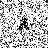

In [99]:
img = learn.loss_func.ocr_loss.stored[0]["inp"][0]
print(img.mean(), learn.loss_func.ocr_loss.stored[0]["loss"])
img_from_tensor(img)

In [100]:
font_path = SYS_FONT_PATH/"Arial Bold.ttf"
img_arial = render_text(font_path, "A", text_size=28, y=24, image_width=28, as_normalised_array=True)
print(img_arial.mean())

0.7785964385754301


In [101]:
t_arial = tensor(img_arial).unsqueeze(0).unsqueeze(0)
t_arial.shape

torch.Size([1, 1, 28, 28])

In [102]:
loss = learn.loss_func.ocr_loss(t_arial, tensor([0]))
loss

TensorBase(3.2868, grad_fn=<AliasBackward0>)

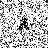

TensorCategory([4.1389], grad_fn=<AliasBackward0>)
tensor(0.0643)
tensor(0.0299)
H


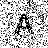

TensorBase([3.2868], grad_fn=<AliasBackward0>)
tensor(0.0844)
tensor(0.0374)
G


In [105]:
for o in learn.loss_func.ocr_loss.stored:
    display(img_from_tensor(o["inp"][0]))
    print(o["losses"][0])
    print(F.softmax(o["pred"][0], dim=-1).max())
    print(F.softmax(o["pred"][0], dim=-1)[learn.vocab.index("A")])
    print(learn.vocab[F.softmax(o["pred"][0], dim=-1).argmax()])



In [89]:
df_arial = get_font_df([font_path], font_size=1., font_y=24/28, vocab="A")
df_arial.drop(columns=["Letter_idx"]).iloc[0].mean()

56.43494897959184

## Export

In [1]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_ocr_model_training_1.ipynb.
Converted 01_fontlearnertests.ipynb.
Converted 02_first_letter_and_optim_tests.ipynb.
Converted 03_vector_models.ipynb.
Converted 04_font_statistics.ipynb.
Converted 05_full_aphabet_optimisation.ipynb.
Converted 06_data_augmentation.ipynb.
Converted 07_optimising_with_augmentation.ipynb.
Converted 08_comparing_existing_fonts.ipynb.
Converted 09_experiment_1_optimise_to_match_font.ipynb.
Converted 10_optimising_with_aug_run_2.ipynb.
Converted 11_optimise_to_match_font_multires.ipynb.
Converted 12_optimising_with_aug_with_multiple_ocr_models.ipynb.
Converted 13_analysing_ocr_models.ipynb.
Converted 14_experiment_2_ocrlearner_training_with_emp_data.ipynb.
Converted 15_experiment_3_optimise_with_emp_model.ipynb.
Converted 16_experiment_2_rerun.ipynb.
Converted 17_experiment_3_rerun.ipynb.
Converted aifont_core.ipynb.
Converted aifont_fontlearner.ipynb.
Converted aifont_fontsampler.ipynb.
Converted aifont_ocrlearner.ipynb.
Converted index.ipynb.
